In [91]:
import torch
import numpy as np
import matplotlib.pyplot as plt
# Creating custom legend handles
import matplotlib.lines as mlines
import sys
import os
import re
from tqdm import tqdm

def path_link(path:str):
    sys.path.append(path)

path_link('/home/jpierre/v2/lib')

import utils2.testing_gen as gen
import utils2.loading as load
import utils2.nn_gen as nn_gen
from utils2.tools import array2List

from NNSimulator import genSim, getSimulationData


from norm import normalizeGraph

from measure import Param_eval, EvaluationCfg, evaluateLoad, saveLoader

import cv2

from torch_geometric.data import Data


In [34]:
CFG_VIDEO = {'radius': 5, 'color': (0, 255, 0)}


class videoParameters():
    def __init__(self, path:str, params = CFG_VIDEO):
        """ 
        Args:
        -----
            - `path`: path of the video
        """
        self.fps = 10
        self.path = path
        self.size = (600, 600)
        self.params = params


def display_out_graph(data_graph, video_params, bounds=None):
    """
    Creates an MP4 video from a PyTorch tensor representing graph nodes and edges using cv2,
    based on specified video parameters and position bounds.

    Parameters:
    - data_x: List of input features of the graph
    - edge_indices: List of tensors for the different indices
    - video_params: An instance of VideoParameters class containing video settings.
    - bounds: Tuple of ((min_x, max_x), (min_y, max_y)) specifying the bounds for the positions.
              If None, uses the minimum and maximum values from the data.
    """


    ## get back the array with teh positions

    mat_pos = []
    mat_indices = []

    for i in range(len(data_graph)):
        mat_pos.append(data_graph[i].x[:, :2])

        mat_indices.append(data_graph[i].edge_index)    


    mat_pos = np.stack(mat_pos, axis = 0)  
    #print(len(mat_indices))
    #print(mat_pos.shape)
        
    if bounds:
        min_x, max_x = bounds[0]
        min_y, max_y = bounds[1]
    else:
        min_x, max_x = mat_pos[:, :, 0].min(), mat_pos[:, :, 0].max()
        min_y, max_y = mat_pos[:, :, 1].min(), mat_pos[:, :, 1].max()

    # Normalize coordinates to fit within the video frame size
    mat_pos[:, :, 0] = (mat_pos[:, :, 0] - min_x) / (max_x - min_x) * (video_params.size[0] - 1)
    mat_pos[:, :, 1] = (mat_pos[:, :, 1] - min_y) / (max_y - min_y) * (video_params.size[1] - 1)

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Be sure to use lowercase
    out = cv2.VideoWriter(video_params.path, fourcc, video_params.fps, video_params.size)
    
    mat_pos = mat_pos.astype(int)

    for i in range(mat_pos.shape[0]):
        frame = np.zeros((video_params.size[1], video_params.size[0], 3), dtype=np.uint8)

        # Draw nodes
        for x, y in mat_pos[i]:
            cv2.circle(frame, (x, y), 3, (0, 255, 0), -1)

        # Draw edges
        for start_node, end_node in mat_indices[i].t().numpy():
            pt1 = tuple(mat_pos[i, start_node, :])
            pt2 = tuple(mat_pos[i, end_node, :])
            cv2.line(frame, pt1, pt2, (0, 0, 255), 2)


        out.write(frame)

    out.release()

In [105]:
def compareVideo(data, ground_truth, video_params, bounds=None):
    """
    Creates an MP4 video from a PyTorch tensor representing cell movements using cv2,
    and includes ground truth data visualized in a different color.

    Parameters:
    - data: A PyTorch tensor of shape [T, N, 2], where T is the number of timesteps,
            N is the number of cells, and 2 corresponds to the coordinates (x, y).
    - ground_truth: A PyTorch tensor of shape [T, N, 2], same format as data, representing the ground truth.
    - video_params: An instance of videoParameters class containing video settings.
    - bounds: Tuple of ((min_x, max_x), (min_y, max_y)) specifying the bounds for the positions.
              If None, it uses the minimum and maximum values from the data.
    """
    
    if bounds:
        min_x, max_x = bounds[0]
        min_y, max_y = bounds[1]
    else:
        min_x, max_x = min(data.min(), ground_truth.min()), max(data.max(), ground_truth.max())
        min_y, max_y = min(data.min(), ground_truth.min()), max(data.max(), ground_truth.max())

    # Normalize coordinates to fit within the video frame size
    data[:, :, 0] = (data[:, :, 0] - min_x) / (max_x - min_x) * (video_params.size[0] - 1)
    data[:, :, 1] = (data[:, :, 1] - min_y) / (max_y - min_y) * (video_params.size[1] - 1)
    ground_truth[:, :, 0] = (ground_truth[:, :, 0] - min_x) / (max_x - min_x) * (video_params.size[0] - 1)
    ground_truth[:, :, 1] = (ground_truth[:, :, 1] - min_y) / (max_y - min_y) * (video_params.size[1] - 1)

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Be sure to use lowercase
    out = cv2.VideoWriter(video_params.path, fourcc, video_params.fps, video_params.size)

    # Colors (BGR format) and radius
    pred_color = (0, 255, 0)  # Green for predictions
    gt_color = (0, 0, 255)  # Red for ground truth

    for i in range(data.shape[0]):
        frame = np.zeros((video_params.size[1], video_params.size[0], 3), dtype=np.uint8)
        
        # Draw ground truth and predictions
        for (x, y), (gt_x, gt_y) in zip(data[i], ground_truth[i]):
            cv2.circle(frame, (int(x), int(y)), radius=5, color=pred_color, thickness=-1)
            cv2.circle(frame, (int(gt_x), int(gt_y)), radius=2, color=gt_color, thickness=-1)
        
        # Draw legend
        cv2.rectangle(frame, (10, 10), (10 + 20, 30), pred_color, -1)  # Prediction color box
        cv2.rectangle(frame, (10, 40), (10 + 20, 60), gt_color, -1)  # Ground truth color box
        cv2.putText(frame, 'Prediction', (35, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
        cv2.putText(frame, 'Ground Truth', (35, 55), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

        out.write(frame)

    out.release()

In [92]:
def getGraphs(sims: np.array, features_x = 'delta', feature_edge = 'first'):

    listGraphs = []
    for i_sim in range(sims.shape[0]):

        if features_x == 'delta':
            x, y, attr, inds = ft.processSimulation(sims[i_sim])
        elif features_x == 'v':
            x, y, attr, inds = ft_v.processSimulation(sims[i_sim])
        # process it

        for i_t in range(len(x)):
            g = Data(x = x[i_t], y = y[i_t], edge_attr = attr[i_t], edge_index = inds[i_t])
            g = normalizeGraph(g)
            listGraphs.append(g)

    return listGraphs

In [2]:
def errorsDiv(pred, gt):
    
    v = np.pi * 2
    anglePred = np.arctan2(pred[:, 1], pred[:, 0])
    angleGT = np.arctan2(gt[:, 1], gt[:, 0])

    normPred = np.linalg.norm(pred, axis=-1)
    normGT = np.linalg.norm(gt, axis=-1)

    errorNorm = np.abs(normPred - normGT)
    errorAngle = errorAngle = np.abs((anglePred - angleGT + np.pi) % (2 * np.pi) - np.pi)

    return errorAngle, errorNorm

In [3]:
import stats.stats_re as stats
import yaml

In [124]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

PATH = ['/home/jpierre/v2/results_end/files/baseline/mt-baseline_normal_dt-0.001_tr-1-step_NLayers-0_dropout-0_layerNorm-0',
       '/home/jpierre/v2/results_end/files/simplest/mt-simplest_normal_scaleL1-0.01_dropout-0',
       '/home/jpierre/v2/results_end/files/gnn-2/Alan2/mt_compex_normal_nbLyaer-2_dropout-0_layerNorm-0',
       '/home/jpierre/v2/results_end/files/roll/gat/mt_gat_normal_nbLyaer-2_dropout-0_layerNorm-1']

"""
PATH = ['/home/jpierre/v2/results_end/files/roll/baseline/mt-baseline_noisy_dt-0.001_tr-rollout_NLayers-0_dropout-0_layerNorm-0',
       #'/home/jpierre/v2/results_end/files/roll/simplest/mt-simplest_noisy_scaleL1-0.0001_dropout-0',
       '/home/jpierre/v2/results_end/files/ro'
       '/home/jpierre/v2/results_end/files/gnn-1/Alan1/mt_compex_noisy_nbLyaer-2_dropout-0_layerNorm-0'',
       '/home/jpierre/v2/results_end/files/roll/mt_gat_noisy_nbLyaer-2_dropout-0_layerNorm-1']
"""
MODEL_PATH = '/home/jpierre/v2/results_end/models'
MODEL = ['baseline', 'simplest', 'compex', 'gat']

In [125]:
print(os.path.exists('/home/jpierre/v2/results_end/files/gnn-1/Alan1'))

True


In [6]:
print(os.listdir('/home/jpierre/v2/results_end/files/roll/simplest'))

['mt-simplest_noisy_scaleL1-0.0001_dropout-0', 'mt-simplest_normal_scaleL1-0.0001_dropout-0']


In [7]:
l1 = ['Baseline', 'IN', 'EPD-GNN', 'EDP-GAT']
colors = ['green', 'red', 'blue', 'orange']

In [8]:
def loadModel(modelName:str, d, path = MODEL_PATH):
    """ 
    Function to import the model

    Args:
    -----
        - `modelName`: name of the model
        - `inputShape`: inout shape of the NN
        - `edges_shape`: edge shape of the NN
        - `path`: path where the models are
    """

    sys.path.append(path)

    loadFun = __import__(f'{modelName}', fromlist = ('loadNetwork'))

    #model = loadFun.loadNetwork(inputShape, edges_shape)
    model = loadFun.loadNetwork(d)

    return model


In [9]:
def getModel(cfg, std_path, device = DEVICE, model_path = MODEL_PATH, model_name = MODEL):

    with open(cfg, 'r') as file:
        cfg = yaml.safe_load(file) 

    trainingInfos = cfg['training']

    d_model = trainingInfos['cfg_mod'][f'{trainingInfos["cfg_mod"]["model_name"]}']


    model = loadModel(model_name, d_model, model_path)



    state_dict = torch.load(std_path, map_location = 'cpu')

    model.load_state_dict(state_dict)

    model.eval()

    model = model.to(device)

    return model

    

In [10]:
class id():
    def __init__(self):
        self.dropout = None
        self.l1 = None
        self.path = None
        self.loss = None
        self.eval_loss = None
        self.eval_sim_loss = None
        self.data_type = None
        self.action_r = None
        self.cfg = None


    def load_id(self, path:str):
        try:
            if 'scaleL1' in path:
                nb_layer_match = re.search(r'scaleL1-(\d+\.\d+|\d+)', path)
                self.l1 = float(nb_layer_match.group(1))
            dropout_match = re.search(r'dropout-(\d+)', path)


            if 'action' in path:
                self.action_r = 1
            else:
                0



            self.dropout = int(dropout_match.group(1))

            if 'noisy' in path:
                self.data_type = 'noisy'

            elif 'normal' in path:
                self.data_type = 'normal'
            
            
            self.path = path

            self.loss = os.path.join(os.path.dirname(path), 'loss_list.npy')
            self.eval_loss = os.path.join(os.path.dirname(path), 'eval_list.npy')
            self.eval_sim_loss = os.path.join(os.path.dirname(path), 'eval_sim_list.npy')
            self.cfg = os.path.join(os.path.dirname(os.path.dirname(path)), 'cfg.yml')
        except:
            print(path)

    def label(self):
        return f'{self.data_type}_action-{self.action_r}_dropout{self.dropout}_l1-{self.l1}'
    

def get_path_models(path):

    res = []

    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('best.pt'):
                id_model = id()
                id_model.load_id(os.path.join(root, file))

                res.append(id_model)


    return res




res = []

for path in PATH:
    res.extend(get_path_models(path))

In [11]:
for r in res:
    print(f'{r.path} >>> {r.__dict__}')

/home/jpierre/v2/results_end/files/baseline/mt-baseline_normal_dt-0.001_tr-1-step_NLayers-0_dropout-0_layerNorm-0/model_trained/baseline_best.pt >>> {'dropout': 0, 'l1': None, 'path': '/home/jpierre/v2/results_end/files/baseline/mt-baseline_normal_dt-0.001_tr-1-step_NLayers-0_dropout-0_layerNorm-0/model_trained/baseline_best.pt', 'loss': '/home/jpierre/v2/results_end/files/baseline/mt-baseline_normal_dt-0.001_tr-1-step_NLayers-0_dropout-0_layerNorm-0/model_trained/loss_list.npy', 'eval_loss': '/home/jpierre/v2/results_end/files/baseline/mt-baseline_normal_dt-0.001_tr-1-step_NLayers-0_dropout-0_layerNorm-0/model_trained/eval_list.npy', 'eval_sim_loss': '/home/jpierre/v2/results_end/files/baseline/mt-baseline_normal_dt-0.001_tr-1-step_NLayers-0_dropout-0_layerNorm-0/model_trained/eval_sim_list.npy', 'data_type': 'normal', 'action_r': None, 'cfg': '/home/jpierre/v2/results_end/files/baseline/mt-baseline_normal_dt-0.001_tr-1-step_NLayers-0_dropout-0_layerNorm-0/cfg.yml'}
/home/jpierre/v2/r

In [12]:
normal_runs = []
noisy_runs = []


for r in res:
    if r.data_type == 'normal':
        normal_runs.append(r)
    elif r.data_type == 'noisy':
        noisy_runs.append(r)
        
        
        
normal_models_l1 = []
normal_l1_val = []

noisy_models_l1 = []
noisy_l1_val = []


for r in normal_runs:
    if r.data_type == 'normal':
        if r.dropout == 0:
            l1_val = r.l1
            normal_l1_val.append(l1_val)


            normal_models_l1.append(r)



for r in noisy_runs:
    if r.data_type == 'noisy':
        if r.dropout == 0:
            l1_val = r.l1
            noisy_l1_val.append(l1_val)


            noisy_models_l1.append(r)


In [13]:
NB_SIM = 5


def getParams():
    params = gen.Parameters_Simulation()  


    params.dt = 0.001
    params.v0 = 60
    params.k = 70
    params.epsilon = 0.5
    params.tau = 3.5
    params.R = 1
    params.N = 200
    params.boundary = 100
    params.nbStep = 1000


    params.noisy = 0        # function dans utils
    params.features_x = 'delta'
    params.features_edge = 'first'


    return params


params1 = getParams()

params2 = getParams()
params2.noisy = 1


data_gt_1  = gen.get_mult_data(params1, NB_SIM)
graphs_gt_1  = gen.sims2Graphs(data_gt_1, params1.features_x)
data_gt_list_1 = array2List(data_gt_1)


#data_gt_2 = gen.get_mult_data(params2, NB_SIM)
#graphs_gt_2 = gen.sims2Graphs(data_gt_2, params2.features_x)
#data_gt_list_2 = array2List(data_gt_2)

0
v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 999/999 [00:13<00:00, 74.43it/s] 


0
v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 999/999 [00:12<00:00, 78.89it/s] 


0
v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 999/999 [00:12<00:00, 79.78it/s] 


0
v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 999/999 [00:12<00:00, 77.13it/s] 


0
v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 999/999 [00:12<00:00, 81.48it/s] 


In [98]:
start = 250
length = 500

stop = start+length

In [100]:
data_path = '/scratch/users/jpierre/mew_0.001_normal_v2/training/np_file/simulation_13.npy'


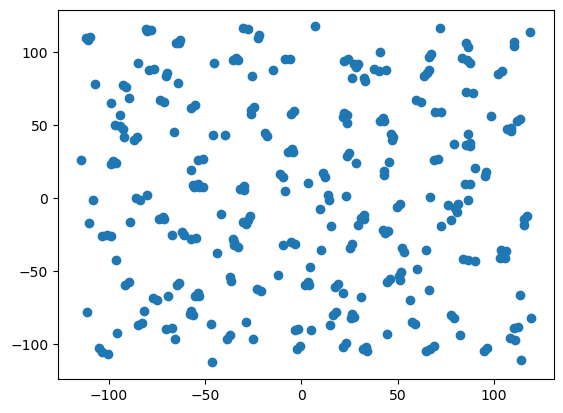

In [101]:
dataset = 'mew_0.001_normal_v2'
torch_dataset = f'/scratch/users/jpierre/{dataset}/training/torch_file'
np_dataset = f'/scratch/users/jpierre/{dataset}/training/np_file'
df_file = f'/scratch/users/jpierre/{dataset}'
x = np.load(os.path.join(np_dataset, 'simulation_8.npy'))

plt.scatter(x[start, :, 0], x[start, :, 1])

In [102]:
import features as ft
x_data = getGraphs(x)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [103]:
print()

In [104]:
nb_sim = 5

p = os.getcwd()


for j in range(nb_sim):
    
    data_r  = getGraphs(data_gt_1[j, start:(start+length), :, :][None, :, :, :], params1.features_x)
    params = videoParameters(path = os.path.join(p, f'gt_{j}.mp4'))
    display_out_graph(data_r.copy(), params)
    

for i in tqdm(range(len(normal_models_l1))):
    
    # load model
    
    cfg = normal_models_l1[i].cfg
    std_path = normal_models_l1[i].path
    model = getModel(cfg, std_path, model_name = MODEL[i])
    
    for j in range(nb_sim):
        
        res = getSimulationData(model, length, mat.copy(), i = start, device = DEVICE).cpu().numpy()
        r  = getGraphs(res[None, :, :, :], params1.features_x)
        
        
        
        #for k in range(len(r)):
        #    r[k].edge_index = torch.zeros_like(r[k].edge_index)
        
        params = videoParameters(path = os.path.join(p, f'{MODEL[i]}_{j}.mp4'))
        
        
            
        display_out_graph(r, params)
        
        


  0%|          | 0/4 [00:00<?, ?it/s]

>>>> loading baseline
INFO >>> Forcing D = 2
INFO >>> with NO encoder
INFO >>> with NO dropout



100%|██████████| 500/500 [00:01<00:00, 476.89it/s]

100%|██████████| 500/500 [00:01<00:00, 482.52it/s]

100%|██████████| 500/500 [00:01<00:00, 480.17it/s]

100%|██████████| 500/500 [00:01<00:00, 481.51it/s]

 25%|██▌       | 1/4 [00:26<01:18, 26.30s/it]

>>>> loading simplest
INFO >>> with NO encoder
INFO >>> with NO dropout



100%|██████████| 500/500 [00:01<00:00, 480.43it/s]

100%|██████████| 500/500 [00:01<00:00, 481.56it/s]

100%|██████████| 500/500 [00:01<00:00, 481.71it/s]

100%|██████████| 500/500 [00:01<00:00, 481.74it/s]

 50%|█████     | 2/4 [00:52<00:52, 26.38s/it]

>>>>>>>>>>> Loading Compex model



100%|██████████| 500/500 [00:01<00:00, 285.90it/s]

100%|██████████| 500/500 [00:01<00:00, 272.38it/s]

100%|██████████| 500/500 [00:01<00:00, 285.90it/s]

100%|██████████| 500/500 [00:01<00:00, 286.74it/s]

 75%|███████▌  | 3/4 [01:22<00:27, 27.72s/it]

>>>>>>>>>>> Loading GaT model



100%|██████████| 500/500 [00:01<00:00, 274.06it/s]

100%|██████████| 500/500 [00:01<00:00, 272.12it/s]

100%|██████████| 500/500 [00:01<00:00, 274.41it/s]

100%|██████████| 500/500 [00:01<00:00, 274.73it/s]

100%|██████████| 4/4 [01:52<00:00, 28.16s/it]


In [112]:
nb_sim = 5

p = os.getcwd()


for j in range(nb_sim):
    
    data_r  = getGraphs(data_gt_1[j, start:(start+length), :, :][None, :, :, :].copy(), params1.features_x)
    params = videoParameters(path = os.path.join(p, f'gt_{j}.mp4'))
    display_out_graph(data_r.copy(), params)
    

for i in tqdm(range(len(normal_models_l1))):
    
    # load model
    
    cfg = normal_models_l1[i].cfg
    std_path = normal_models_l1[i].path
    model = getModel(cfg, std_path, model_name = MODEL[i])
    
    for j in range(nb_sim):
        
        res = getSimulationData(model, length, data_gt_1[j].copy(), i = start, device = DEVICE).cpu().numpy()
        #r  = getGraphs(res[None, :, :, :], params1.features_x)
        
        
        
        #for k in range(len(r)):
        #    r[k].edge_index = torch.zeros_like(r[k].edge_index)
        
        params = videoParameters(path = os.path.join(p, f'{MODEL[i]}_{j}-v2.mp4'))
        
        
            
        compareVideo(res.copy(), data_gt_1[j, start:(start+length+1), :, :].copy(), params, bounds=((-140, 140), (-140, 140)))
        
        


  0%|          | 0/4 [00:00<?, ?it/s]

>>>> loading baseline
INFO >>> Forcing D = 2
INFO >>> with NO encoder
INFO >>> with NO dropout



100%|██████████| 500/500 [00:01<00:00, 480.52it/s]

100%|██████████| 500/500 [00:01<00:00, 481.44it/s]

100%|██████████| 500/500 [00:01<00:00, 480.79it/s]

100%|██████████| 500/500 [00:01<00:00, 481.22it/s]

 25%|██▌       | 1/4 [00:13<00:41, 13.78s/it]

>>>> loading simplest
INFO >>> with NO encoder
INFO >>> with NO dropout



100%|██████████| 500/500 [00:01<00:00, 479.84it/s]

100%|██████████| 500/500 [00:01<00:00, 480.28it/s]

100%|██████████| 500/500 [00:01<00:00, 473.79it/s]

100%|██████████| 500/500 [00:01<00:00, 481.21it/s]

 50%|█████     | 2/4 [00:27<00:27, 13.76s/it]

>>>>>>>>>>> Loading Compex model



100%|██████████| 500/500 [00:01<00:00, 285.28it/s]

100%|██████████| 500/500 [00:01<00:00, 285.70it/s]

100%|██████████| 500/500 [00:01<00:00, 277.57it/s]

100%|██████████| 500/500 [00:01<00:00, 286.03it/s]

 75%|███████▌  | 3/4 [00:44<00:15, 15.44s/it]

>>>>>>>>>>> Loading GaT model



100%|██████████| 500/500 [00:01<00:00, 274.25it/s]

100%|██████████| 500/500 [00:01<00:00, 272.65it/s]

100%|██████████| 500/500 [00:01<00:00, 274.30it/s]

100%|██████████| 500/500 [00:01<00:00, 274.47it/s]

100%|██████████| 4/4 [01:02<00:00, 15.67s/it]


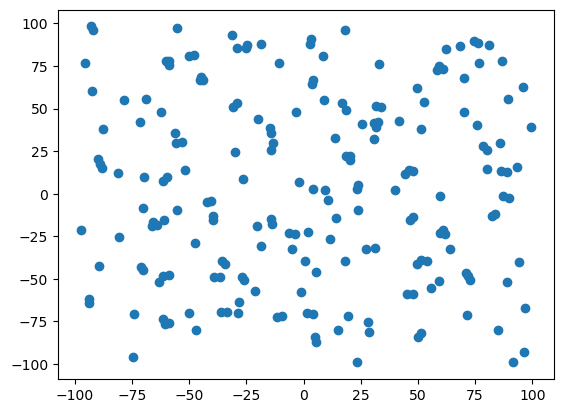

In [111]:
plt.scatter(data_gt_1[j, start, :, 0], data_gt_1[j, start, :, 1])
plt.scatter()

In [18]:
print(res[0, :, 0])

tensor([-77.1263, -68.5335, -53.7041, -39.6504, -22.0113,  13.3579,  23.6918,
         32.2559,  72.2958,  87.4800, -82.0913, -60.0779, -45.7711, -43.0596,
         -1.7161,  -0.4319,  25.9245,  53.2561,  54.9231,  77.1020, -87.9595,
        -81.0584, -38.7231, -20.7445,   2.9126,   4.9303,  41.0351,  61.9150,
         63.3615,  86.9289, -75.6348, -54.7775, -57.5647, -41.0947, -21.4259,
          3.8026,  30.0017,  43.2069,  63.1566,  76.0917, -98.4388, -67.3997,
        -62.2785, -23.4836, -19.5428,  24.2458,  26.5229,  35.3503,  73.6664,
         71.8306, -97.8496, -61.7679, -56.2135, -24.0269,  -0.1029,  -2.0599,
         20.3725,  46.5504,  51.6605,  70.9179, -94.4955, -56.5363, -56.2086,
        -22.4909, -17.7505,   8.5264,  23.9919,  45.3344,  63.3875,  70.9127,
        -70.9561, -63.7319, -51.0463, -17.6311,   3.9854,  15.4218,  40.4892,
         37.3967,  51.3421,  99.7509, -73.8414, -65.6847, -41.4208, -42.6577,
        -21.5085,  -1.4842,  30.7830,  39.4626,  51.9951,  74.77

In [19]:
print(data_gt_1[0, start, :, 0])

[-77.12631832 -68.53353881 -53.70405457 -39.65038118 -22.01125421
  13.35788806  23.69183615  32.25592711  72.29581109  87.48003429
 -82.09134876 -60.07794295 -45.77114488 -43.05964475  -1.71610717
  -0.43191383  25.92450797  53.2560766   54.92312777  77.10197359
 -87.95950955 -81.05838553 -38.7230647  -20.74448026   2.91264237
   4.9302619   41.03513617  61.91502251  63.36150025  86.92888886
 -75.63483953 -54.77753941 -57.56474722 -41.09467315 -21.42593104
   3.80261911  30.00168593  43.20691111  63.15660775  76.09169473
 -98.43877577 -67.39967442 -62.27849135 -23.48359087 -19.54277921
  24.24581281  26.52294492  35.35025091  73.6664111   71.83055838
 -97.84955654 -61.7678969  -56.21354156 -24.02685747  -0.10291336
  -2.05991646  20.37254051  46.55043703  51.66050233  70.91789174
 -94.49553773 -56.53626876 -56.20864663 -22.49091649 -17.75051174
   8.52636216  23.99185522  45.33435654  63.38750095  70.91270756
 -70.95609534 -63.73190893 -51.04625209 -17.63105759   3.98537063
  15.42183

In [21]:
print(res[:, 0, 0])

tensor([-77.1263, -77.1109, -77.0961, -77.0827, -77.0699, -77.0575, -77.0455,
        -77.0337, -77.0221, -77.0106, -76.9992, -76.9878, -76.9765, -76.9653,
        -76.9541, -76.9429, -76.9317, -76.9205, -76.9093, -76.8981, -76.8869,
        -76.8757, -76.8645, -76.8533, -76.8421, -76.8309, -76.8197, -76.8085,
        -76.7973, -76.7861, -76.7749, -76.7636, -76.7524, -76.7411, -76.7299,
        -76.7186, -76.7073, -76.6960, -76.6847, -76.6734, -76.6621, -76.6508,
        -76.6395, -76.6282, -76.6168, -76.6055, -76.5941, -76.5827, -76.5714,
        -76.5600, -76.5486, -76.5372, -76.5258, -76.5144, -76.5029, -76.4915,
        -76.4800, -76.4686, -76.4571, -76.4456, -76.4341, -76.4226, -76.4111,
        -76.3996, -76.3880, -76.3765, -76.3649, -76.3534, -76.3418, -76.3302,
        -76.3186, -76.3070, -76.2953, -76.2837, -76.2720, -76.2604, -76.2487,
        -76.2370, -76.2253, -76.2136, -76.2018, -76.1901, -76.1783, -76.1665,
        -76.1547, -76.1429, -76.1311, -76.1192, -76.1074, -76.09

In [23]:
data_gt_1[0][start:(start + 100), 0, 0]

array([-77.12631832, -77.10646627, -77.08661469, -77.06676355,
       -77.04691283, -77.02706252, -77.0072126 , -76.98736305,
       -76.96751387, -76.94766503, -76.92781652, -76.90796833,
       -76.88812044, -76.86827285, -76.84842555, -76.82857851,
       -76.80873173, -76.7888852 , -76.76903891, -76.74919285,
       -76.72934701, -76.70950139, -76.68965596, -76.66981073,
       -76.64996569, -76.63012083, -76.61027614, -76.59043162,
       -76.57058726, -76.55074305, -76.53089899, -76.51105506,
       -76.49121128, -76.47136762, -76.45152409, -76.43168067,
       -76.41183737, -76.39199419, -76.3721511 , -76.35230812,
       -76.33246524, -76.31262245, -76.29277975, -76.27293714,
       -76.25309461, -76.23325216, -76.21340979, -76.19356749,
       -76.17372526, -76.1538831 , -76.134041  , -76.11419896,
       -76.09435699, -76.07451507, -76.05467321, -76.0348314 ,
       -76.01498964, -75.99514793, -75.97530627, -75.95546465,
       -75.93562307, -75.91578154, -75.89594004, -75.87

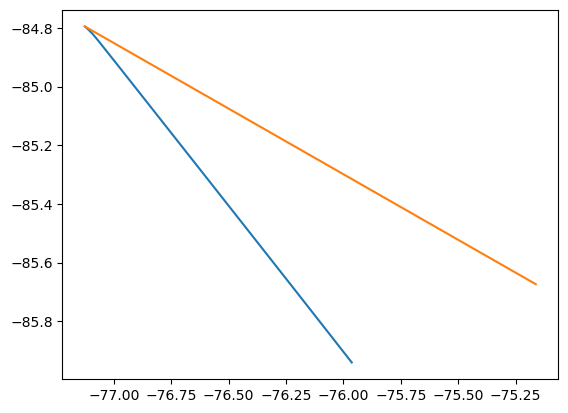

In [28]:
plt.plot(res[:, 0, 0].cpu(), res[:, 0, 1].cpu())
plt.plot(data_gt_1[0][start:(start + 100), 0, 0], data_gt_1[0][start:(start + 100), 0, 1])

In [15]:

a = np.linspace(0, 5, 100)
b= np.linspace(-5, 5, 100)



MSD_base_normal = stats.MSD_stat(data_gt_1[:, start:stop])
RDF_base_normal  = stats.apply_rdf(data_gt_1[:, start:stop])
SCAT_base_normal = stats.applySelfScattering(data_gt_1[:, start:stop])
DISTR_base_normal = stats.apply_hist(data_gt_1, a, b)
SUM_base_normal = stats.sumSpeeds(data_gt_1[:, start:stop])        # issue wiht libtrayr

100%|██████████| 100/100 [00:00<00:00, 160.12it/s]


In [16]:
# laoders
import dataLoading as dl
from torch_geometric.loader import DataLoader
from torch.utils.data import DataLoader as DataLoaderPy




PATH_BASE = '/home/jpierre/v2/path_datasets'

def getLoader(path, batch_size = 32, shuffleBool = True, root = None, jsonFile = None, mode = 'training'):
    datasetTraining = dl.DataLoader2(root, path = path, jsonFile = jsonFile, mode = mode)
    loader = DataLoader(datasetTraining, batch_size=batch_size, shuffle = shuffleBool)
    
    return loader

# 1s-tep loader
p_data = '/scratch/users/jpierre/mew_0.001_normal_v2'
#p_data = '/scratch/users/jpierre/mew_0.001_noisy_v2'

batchSizeEval = 128
p_json = os.path.join(PATH_BASE, f'{p_data.split("/")[-1]}.json')

loaderEval = getLoader(p_data, batch_size = batchSizeEval, jsonFile = p_json, mode = 'validation')


# rollout laoder

p_sim = os.path.join(p_data, 'validation/np_file')

loaderSim = dl.simLoader2(p_sim)
loaderSim = DataLoaderPy(loaderSim, batch_size=1, shuffle=False)

1it [00:00,  4.65it/s]


In [20]:
MSD_list_normal = []
RDF_list_normal = []
SCAT_list_normal = []
DISTR_list_normal = []
SUM_list_normal = []
MSE_rollout = []

a = np.linspace(0, 5, 100)
b= np.linspace(-5, 5, 100)



device = DEVICE


errors_list = []
std_errors_list = []
angles_error_list = []
norm_errors_list = []
angle_errors_std_list = []
norm_errors_std_list = []



sim_error_list = []
sim_error_std_list = []




for i in tqdm(range(len(normal_models_l1))):

    ## load model
    cfg = normal_models_l1[i].cfg
    std_path = normal_models_l1[i].path
    model = getModel(cfg, std_path, model_name = MODEL[i])


    ## compute the trajectory

    data_pred = nn_gen.generate_sim_batch(model = model,
                                        gt = data_gt_1, 
                                        initId = start,
                                        nbStep = length,
                                        dt_scale = 1,
                                        device = DEVICE
                                        )

    # compute the stats

    msd = stats.MSD_stat(data_pred.copy())
    rdf = stats.apply_rdf(data_pred.copy())
    scat = stats.applySelfScattering(data_pred.copy())
    speed_distr = stats.apply_hist(data_pred.copy(), a, b)
    sum_speed = stats.sumSpeeds(data_pred.copy())
    mse_roll = stats.apply_mse_roll(data_pred.copy()[:, :length],data_gt_1.copy()[:, start:stop])



    MSD_list_normal.append(msd)
    RDF_list_normal.append(rdf)
    SCAT_list_normal.append(scat)
    DISTR_list_normal.append(speed_distr)
    SUM_list_normal.append(sum_speed)
    MSE_rollout.append(mse_roll)
    
    
    
    errors = []
    normError = []
    angleError = []
    
    for d, _ in tqdm(loaderEval, leave = False):
        d = d.to(device)
        d.x = d.x[:, 2:]
        d = normalizeGraph(d)
        pred = model(d)  
        
        d.y = torch.swapaxes(d.y, 0, 1)
        

        #evalLoss += torch.nn.functional.l1_loss(pred.reshape(-1), d.y[0, :, :].reshape(-1))
        
        
        errors.extend(torch.abs(pred - d.y[0, :, :]).cpu().detach().numpy().tolist())
        
        
        errorAngle, errorNorm = errorsDiv(pred.cpu().detach().numpy(), d.y[0, :, :].cpu().detach().numpy())
        
        normError.extend(errorNorm.tolist())
        angleError.extend(errorAngle.tolist())


    erros1 = np.mean(errors)
    errors_std = np.std(errors)

    angle_error = np.median(errorAngle)
    norm_error = np.median(normError)

    angle_std = np.std(errorAngle)
    norm_std  = np.std(normError)


    # add to the other lists
    errors_list.append(erros1)
    std_errors_list.append(errors_std)
    angles_error_list.append(angle_std)
    norm_errors_list.append(norm_error)
    angle_errors_std_list.append(angle_std)
    norm_errors_std_list.append(norm_std)
    
    
    
    
    ################
    
    
    eval_loss_list = []

    for d, _ in loaderSim:

        d = torch.squeeze(d, dim = 0).numpy()
        start_id = 8       # not 0
        res = getSimulationData(model, 15, d, i = start_id, device = DEVICE)
        L = res.shape[0]

        eval_loss_list.append(torch.nn.functional.l1_loss(res.reshape(-1), torch.from_numpy(d[start_id:(start_id + L), :, :].copy()).reshape(-1).to(device)).cpu().detach().numpy())

    
    
    sim_error_list.append(np.mean(eval_loss_list))
    sim_error_std_list.append(np.std(eval_loss_list))


  0%|          | 0/4 [00:00<?, ?it/s]

>>>> loading baseline
INFO >>> Forcing D = 2
INFO >>> with NO encoder
INFO >>> with NO dropout



100%|██████████| 99/99 [00:00<00:00, 445.61it/s]

100%|██████████| 99/99 [00:00<00:00, 446.36it/s]

100%|██████████| 99/99 [00:00<00:00, 447.07it/s]

100%|██████████| 99/99 [00:00<00:00, 447.58it/s]

100%|██████████| 99/99 [00:00<00:00, 443.75it/s]

100%|██████████| 100/100 [00:00<00:00, 150.97it/s][A

100%|██████████| 100/100 [00:00<00:00, 150.23it/s][A

100%|██████████| 100/100 [00:00<00:00, 148.11it/s][A

100%|██████████| 100/100 [00:00<00:00, 148.31it/s][A

100%|██████████| 100/100 [00:00<00:00, 141.03it/s][A

100%|██████████| 155/155 [01:31<00:00,  2.04it/s]
                                                 
100%|██████████| 15/15 [00:00<00:00, 418.25it/s]

100%|██████████| 15/15 [00:00<00:00, 399.55it/s]

100%|██████████| 15/15 [00:00<00:00, 416.42it/s]

100%|██████████| 15/15 [00:00<00:00, 419.88it/s]

100%|██████████| 15/15 [00:00<00:00, 443.32it/s]

100%|██████████| 15/15 [00:00<00:00, 420.59it/s]

100%|██████████| 15/15 [00:00<00:00, 420.32it/s]

100%|██████████| 15/15 [00:00

>>>> loading simplest
INFO >>> with NO encoder
INFO >>> with NO dropout



100%|██████████| 99/99 [00:00<00:00, 433.41it/s]

100%|██████████| 99/99 [00:00<00:00, 421.30it/s]

100%|██████████| 99/99 [00:00<00:00, 436.25it/s]

100%|██████████| 99/99 [00:00<00:00, 433.73it/s]

100%|██████████| 99/99 [00:00<00:00, 427.36it/s]

100%|██████████| 100/100 [00:00<00:00, 153.20it/s][A

100%|██████████| 100/100 [00:00<00:00, 152.13it/s][A

100%|██████████| 100/100 [00:00<00:00, 150.52it/s][A

100%|██████████| 100/100 [00:00<00:00, 152.66it/s][A

100%|██████████| 100/100 [00:00<00:00, 148.69it/s][A

100%|██████████| 155/155 [01:31<00:00,  1.98it/s]
                                                 
100%|██████████| 15/15 [00:00<00:00, 415.76it/s]

100%|██████████| 15/15 [00:00<00:00, 419.04it/s]

100%|██████████| 15/15 [00:00<00:00, 417.07it/s]

100%|██████████| 15/15 [00:00<00:00, 416.31it/s]

100%|██████████| 15/15 [00:00<00:00, 418.96it/s]

100%|██████████| 15/15 [00:00<00:00, 425.28it/s]

100%|██████████| 15/15 [00:00<00:00, 417.54it/s]

100%|██████████| 15/15 [00:00

>>>>>>>>>>> Loading Compex model



100%|██████████| 99/99 [00:00<00:00, 260.91it/s]

100%|██████████| 99/99 [00:00<00:00, 259.13it/s]

100%|██████████| 99/99 [00:00<00:00, 258.88it/s]

100%|██████████| 99/99 [00:00<00:00, 246.14it/s]

100%|██████████| 99/99 [00:00<00:00, 260.15it/s]

100%|██████████| 100/100 [00:00<00:00, 146.17it/s][A

100%|██████████| 100/100 [00:00<00:00, 147.70it/s][A

100%|██████████| 100/100 [00:00<00:00, 146.47it/s][A

100%|██████████| 100/100 [00:00<00:00, 147.72it/s][A

100%|██████████| 100/100 [00:00<00:00, 147.08it/s][A

100%|██████████| 155/155 [01:33<00:00,  1.89it/s]
                                                 
100%|██████████| 15/15 [00:00<00:00, 260.08it/s]

100%|██████████| 15/15 [00:00<00:00, 256.59it/s]

100%|██████████| 15/15 [00:00<00:00, 255.36it/s]

100%|██████████| 15/15 [00:00<00:00, 255.19it/s]

100%|██████████| 15/15 [00:00<00:00, 254.23it/s]

100%|██████████| 15/15 [00:00<00:00, 255.78it/s]

100%|██████████| 15/15 [00:00<00:00, 255.20it/s]

100%|██████████| 15/15 [00:00

>>>>>>>>>>> Loading GaT model



100%|██████████| 99/99 [00:00<00:00, 221.33it/s]

100%|██████████| 99/99 [00:00<00:00, 246.63it/s]

100%|██████████| 99/99 [00:00<00:00, 254.11it/s]

100%|██████████| 99/99 [00:00<00:00, 254.72it/s]

100%|██████████| 99/99 [00:00<00:00, 254.69it/s]

100%|██████████| 100/100 [00:00<00:00, 153.99it/s][A

100%|██████████| 100/100 [00:00<00:00, 153.33it/s][A

100%|██████████| 100/100 [00:00<00:00, 154.01it/s][A

100%|██████████| 100/100 [00:00<00:00, 153.28it/s][A

100%|██████████| 100/100 [00:00<00:00, 154.43it/s][A

100%|██████████| 155/155 [01:33<00:00,  1.86it/s]
                                                 
100%|██████████| 15/15 [00:00<00:00, 248.94it/s]

100%|██████████| 15/15 [00:00<00:00, 249.68it/s]

100%|██████████| 15/15 [00:00<00:00, 248.56it/s]

100%|██████████| 15/15 [00:00<00:00, 246.04it/s]

100%|██████████| 15/15 [00:00<00:00, 247.86it/s]

100%|██████████| 15/15 [00:00<00:00, 249.23it/s]

100%|██████████| 15/15 [00:00<00:00, 245.39it/s]

100%|██████████| 15/15 [00:00

In [21]:
print(f'errors ==>  {errors_list}')
print(f'errors std ==> {std_errors_list}')
print(f'angle_error ==>  {angles_error_list}')
print(f'angle_std std ==> {angle_errors_std_list}')
print(f'norm_errors_list ==>  {norm_errors_list}')
print(f'norm_errors_std_list std ==> {norm_errors_std_list}')

print(f'sim_error_list ==>  {sim_error_list}')
print(f'sim_error_std_list std ==> {sim_error_std_list}')

errors ==>  [0.007175570233823329, 0.0021585098588192925, 0.0001794614033198141, 0.00031918717562081375]
errors std ==> [0.006486392978482827, 0.002424102689040358, 0.0010675555971248359, 0.0010232507810126951]
angle_error ==>  [0.2771739, 0.05212816, 0.049303588, 0.06029925]
angle_std std ==> [0.2771739, 0.05212816, 0.049303588, 0.06029925]
norm_errors_list ==>  [0.007960375398397446, 0.002538524568080902, 5.62518835067749e-05, 0.00021478161215782166]
norm_errors_std_list std ==> [0.008307865979462148, 0.0029955285372618603, 0.0009600063646118169, 0.0008010791393480566]
sim_error_list ==>  [0.13401523573355043, 0.04848721840531173, 0.023339047054831717, 0.02796847619226408]
sim_error_std_list std ==> [0.004785189015013425, 0.0021621755487400535, 0.002432084804832683, 0.0021396283023508013]


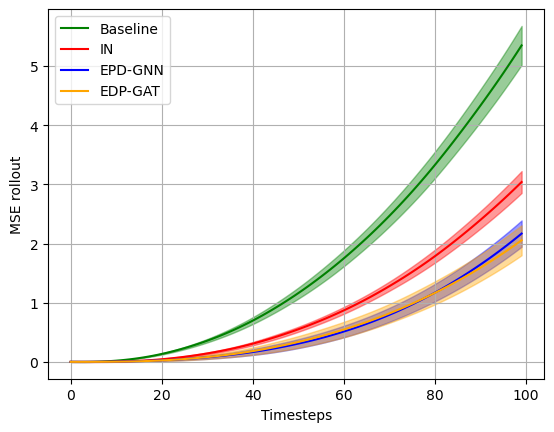

In [22]:
for i in range(len(PATH)):
    m_mean = np.mean(MSE_rollout[i], axis = 0)
    m_std = np.std(MSE_rollout[i], axis = 0)
    
    x_inds = np.arange(m_mean.shape[0])
    plt.plot(x_inds, m_mean, color = colors[i], label = l1[i])
    
    plt.fill_between(x_inds, m_mean - m_std, m_mean +m_std, color = colors[i], alpha = 0.4)
    
    #plt.fill_between()
    
plt.grid()
plt.xlabel('Timesteps')
plt.ylabel('MSE rollout')
plt.legend()
plt.savefig('MSE rollout normal.png')

In [23]:
limit_msd = 99
limit_scat = 99


(5, 99)
(5, 99)
(5, 99)
(5, 99)


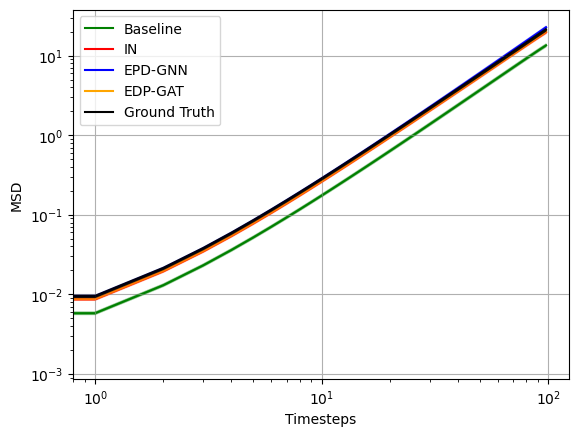

In [24]:
# plot of MSD
res_msd = []

for i in range(len(PATH)):
    print(MSD_list_normal[i][:limit_msd].shape)
    msd_mean = np.mean(MSD_list_normal[i][:, :limit_msd], axis = 0)
    msd_std = np.std(MSD_list_normal[i][:, :limit_msd], axis = 0)
    x = np.arange(limit_msd)
    plt.loglog(x, msd_mean, color = colors[i], zorder = 1, label = str(l1[i]))
    plt.fill_between((x), (msd_mean - msd_std), (msd_mean+msd_std), color = colors[i], alpha = 0.4, zorder = 2)
    
    res_msd.append(msd_mean)
    
msd_mean = np.mean(MSD_base_normal[:, :limit_msd], axis = 0)
msd_std = np.std(MSD_base_normal[:, :limit_msd], axis = 0)
x = np.arange(limit_msd)
plt.loglog(x, msd_mean, color = 'k', zorder = 1, label = 'Ground Truth')
plt.fill_between((x), (msd_mean - msd_std), (msd_mean+msd_std), color = 'k', alpha = 0.8, zorder = 2)
    
plt.xlabel('Timesteps')
plt.ylabel('MSD')
plt.grid()
plt.legend()
plt.savefig('MSD-simplest-normal.png')



In [25]:
msd_gt = np.mean(MSD_base_normal[:, :limit_msd], axis = 0)

In [26]:
for i in range(len(res_msd)):
    delta = (msd_gt - res_msd[i]) ** 2
    print(f'l1: {l1[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

l1: Baseline >>>> 12.282951059990703 +- 16.10993320392999
l1: IN >>>> 0.39806166850902186 +- 0.5670057952841246
l1: EPD-GNN >>>> 0.39192413221169276 +- 0.6133240772392339
l1: EDP-GAT >>>> 0.2423476243612694 +- 0.30559595940914064


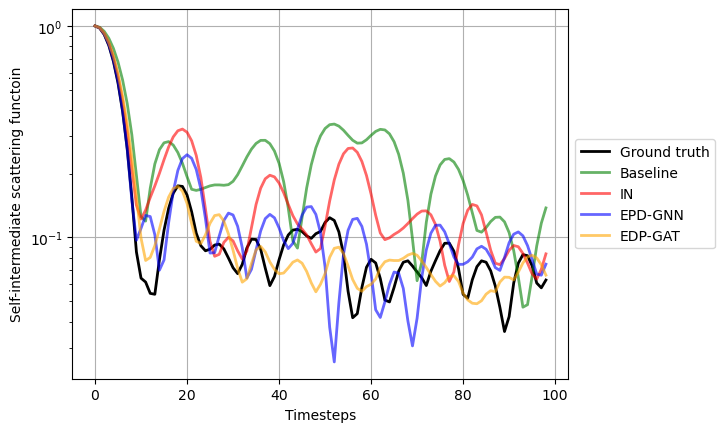

In [37]:
# plot of SSF

res_scat = []


ssf_mean = np.mean(SCAT_base_normal[:, :limit_scat], axis = 0)
ssf_std = np.std(SCAT_base_normal[:, :limit_scat], axis = 0)
t = np.arange(limit_scat)
plt.semilogy(t, ssf_mean, color = 'k', lw=2, label = 'Ground truth')
#plt.fill_between(t, ssf_mean -ssf_std,  ssf_mean + ssf_std, color = 'k', alpha = 0.2, zorder = 3)


for i in range(len(PATH)):
    #print(MSD_list_normal[i][:limit_scat].shape)
    ssf_mean = np.mean(SCAT_list_normal[i][:, :limit_scat], axis = 0)
    ssf_std = np.std(SCAT_list_normal[i][:, :limit_scat], axis = 0)
    t = np.arange(limit_scat)
    res_scat.append(ssf_mean)
    plt.semilogy(t, ssf_mean, color = colors[i], lw=2, label = str(l1[i]), alpha = 0.6)
    #plt.fill_between(t, ssf_mean -ssf_std,  ssf_mean + ssf_std, color = colors[i], alpha = 0.4, zorder = 2)
    
plt.xlabel('Timesteps')
plt.ylabel('Self-intermediate scattering functoin')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('scat-simplest-normal.png', bbox_inches='tight')
plt.show()

In [28]:
scat_gt = np.mean(SCAT_base_normal[:, :limit_scat], axis = 0)

for i in range(len(res_scat)):
    delta = (scat_gt - res_scat[i]) ** 2
    print(f'l1: {l1[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

l1: Baseline >>>> 0.019158679028310144 +- 0.01976834414705661
l1: IN >>>> 0.006274561198304698 +- 0.009937184675930634
l1: EPD-GNN >>>> 0.0014812427099482287 +- 0.0023291578702884157
l1: EDP-GAT >>>> 0.0007362403223267463 +- 0.0012494715471217028


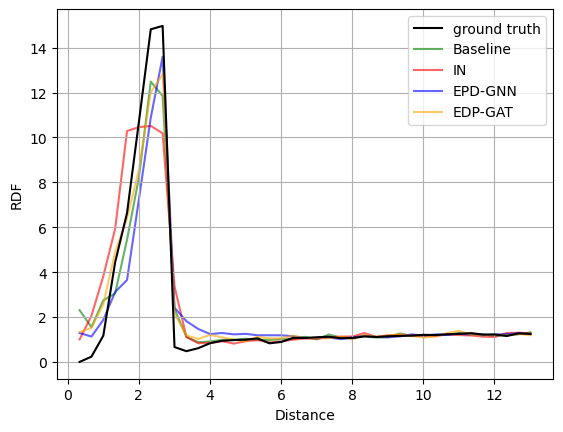

In [36]:
mean_res, std_res, r = RDF_base_normal
lim_rdf = 40

res_rdf = []


mean_res, std_res, r = mean_res[1:lim_rdf], std_res[1: lim_rdf], r[1: lim_rdf]

plt.plot(r, mean_res, color = 'k', label = 'ground truth', zorder = 2)
#plt.fill_between(r, mean_res - std_res, mean_res+ std_res, color = 'k', alpha = 0.4)

for i in range(len(PATH)):
    #print(MSD_list_normal[i][:limit_scat].shape)
    mean_res, std_res, r = RDF_list_normal[i]
    mean_res, std_res, r = mean_res[1:lim_rdf], std_res[1: lim_rdf], r[1: lim_rdf]
    
    plt.plot(r, mean_res, color = colors[i], label = str(l1[i]), alpha = 0.6, zorder = 1)
    #plt.fill_between(r, mean_res -std_res,  mean_res + std_res, color = colors[i], alpha = 0.4, zorder = 2)
    
    res_rdf.append(mean_res)

plt.xlabel('Distance')
plt.ylabel('RDF')
plt.grid()
plt.legend()


plt.savefig('rdf-simplest-normal.png')
plt.show()

In [30]:
mean_res, std_res, r = RDF_base_normal
mean_res, std_res, r = mean_res[1:lim_rdf], std_res[1: lim_rdf], r[1: lim_rdf]
rdf_gt = np.mean(mean_res, axis = 0)

for i in range(len(res_rdf)):
    delta = (rdf_gt - res_rdf[i]) ** 2
    print(f'l1: {l1[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

l1: Baseline >>>> 7.256677703071068 +- 22.249164673618356
l1: IN >>>> 8.29855875048978 +- 19.841439527649197
l1: EPD-GNN >>>> 6.811290711651054 +- 23.43815544454528
l1: EDP-GAT >>>> 7.941795212364254 +- 23.497277692953777


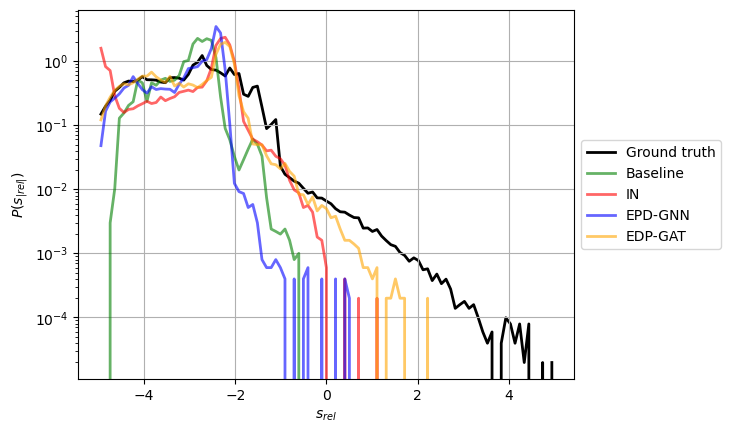

In [38]:
magn_base, x_speed, y_speed = DISTR_base_normal

magn_base_mean = np.mean(magn_base, axis = 0)
magn_base_std = np.std(magn_base, axis = 0)

res_magn_distr = []


fig=plt.figure()
db=b[1]-b[0]
plt.grid()
plt.semilogy(b[1:]-db/2,magn_base_mean,'k',lw=2, zorder = 1, label = 'Ground truth')
#plt.fill_between(b[1:]-db/2, magn_base_mean - magn_base_std, magn_base_mean + magn_base_std, color = 'r', alpha = 0.4)


for i in range(len(PATH)):
    magn, x, y = DISTR_list_normal[i]
    magn_base_mean = np.mean(magn, axis = 0)
    magn_base_std = np.std(magn, axis = 0)
    plt.semilogy(b[1:]-db/2,magn_base_mean, color = colors[i],lw=2, label = str(l1[i]), zorder = 2, alpha = 0.6)
    
    res_magn_distr.append(magn_base_mean)



plt.xlabel('$s_{rel}$')
plt.ylabel('$P(s_{|rel|})$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('speed-magn-simplest-normal.png', bbox_inches='tight')
plt.show()

In [32]:
magn_base, x_speed, y_speed = DISTR_base_normal

magn_base_mean = np.mean(magn_base, axis = 0)

magn_gt = magn_base_mean

for i in range(len(res_magn_distr)):
    delta = (magn_gt - res_magn_distr[i]) ** 2
    print(f'l1: {l1[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

l1: Baseline >>>> 0.10500632673070709 +- 0.3361225831679503
l1: IN >>>> 0.1379610774186087 +- 0.4723956994494341
l1: EPD-GNN >>>> 0.1498829915329603 +- 0.8701161600329107
l1: EDP-GAT >>>> 0.06450115647078103 +- 0.25678668366236973


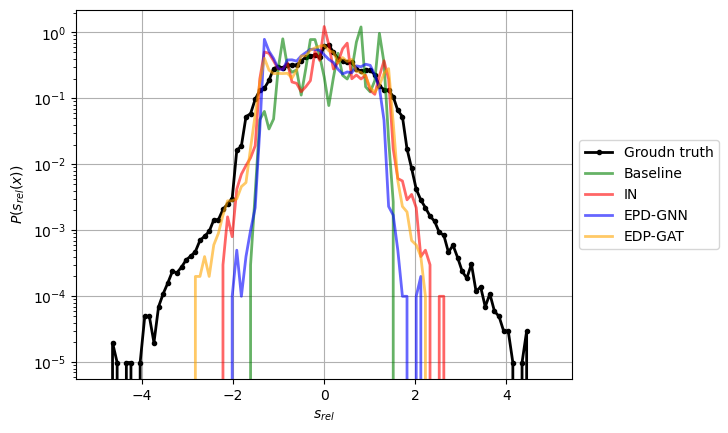

In [33]:
magn_base_mean = np.mean(x_speed, axis = 0)
magn_base_std = np.std(x_speed, axis = 0)

res_magn_x = []


fig=plt.figure()
db=b[1]-b[0]
plt.grid()
plt.semilogy(b[1:]-db/2,magn_base_mean,'k.-',lw=2, label = 'Groudn truth')
#plt.fill_between(b[1:]-db/2, magn_base_mean - magn_base_std, magn_base_mean + magn_base_std, color = 'r', alpha = 0.4)


for i in range(len(PATH)):
    magn, x, y = DISTR_list_normal[i]
    x_base_mean = np.mean(x, axis = 0)
    x_base_std = np.std(x, axis = 0)
    plt.semilogy(b[1:]-db/2,x_base_mean, color = colors[i],lw=2, label = str(l1[i]), zorder = 2, alpha = 0.6)
    
    res_magn_x.append(x_base_mean)

    
plt.xlabel('$s_{rel}$')
plt.ylabel('$P(s_{rel}(x))$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('speed-x-simplest.png', bbox_inches='tight')
plt.show()

In [34]:
magn_base, x_speed, y_speed = DISTR_base_normal

magn_base_mean = np.mean(x_speed, axis = 0)

magn_gt = magn_base_mean

for i in range(len(res_magn_x)):
    delta = (magn_gt - res_magn_x[i]) ** 2
    print(f'l1: {l1[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

l1: Baseline >>>> 0.032168682772272895 +- 0.12051869523981562
l1: IN >>>> 0.012156137124807053 +- 0.04337103767506229
l1: EPD-GNN >>>> 0.008547186594276468 +- 0.043166914068962725
l1: EDP-GAT >>>> 0.0028516194161893175 +- 0.008766972539533601


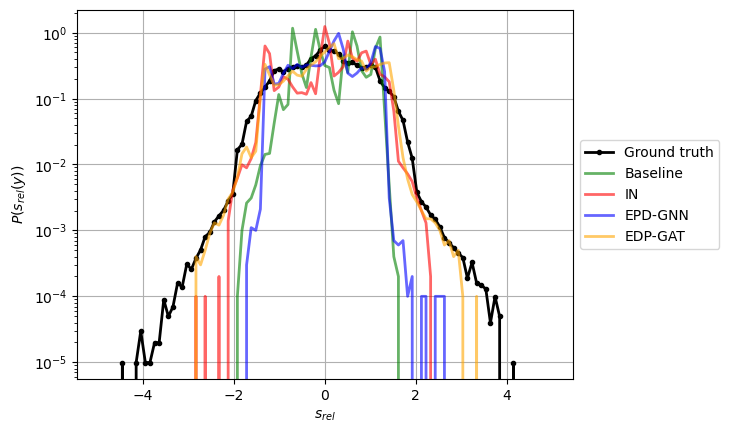

In [35]:
magn_base_mean = np.mean(y_speed, axis = 0)
magn_base_std = np.std(y_speed, axis = 0)

res_magn_y = []


fig=plt.figure()
db=b[1]-b[0]
plt.grid()
plt.semilogy(b[1:]-db/2,magn_base_mean,'k.-',lw=2, label = 'Ground truth')
#plt.fill_between(b[1:]-db/2, magn_base_mean - magn_base_std, magn_base_mean + magn_base_std, color = 'r', alpha = 0.4)


for i in range(len(PATH)):
    magn, x, y = DISTR_list_normal[i]
    y_base_mean = np.mean(y, axis = 0)
    y_base_std = np.std(y, axis = 0)
    plt.semilogy(b[1:]-db/2,y_base_mean, color = colors[i],lw=2, label = str(l1[i]), zorder = 2, alpha = 0.6)
    
    res_magn_y.append(y_base_mean)

plt.xlabel('v/<v>')
plt.ylabel('P(frac{v}{<v>})')




plt.xlabel('$s_{rel}$')
plt.ylabel('$P(s_{rel}(y))$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('speed-y-simplest.png', bbox_inches='tight')
plt.show()

In [ ]:
magn_base, x_speed, y_speed = DISTR_base_normal

magn_base_mean = np.mean(y_speed, axis = 0)

magn_gt = magn_base_mean

for i in range(len(res_magn_y)):
    delta = (magn_gt - res_magn_y[i]) ** 2
    print(f'l1: {l1[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

In [ ]:
mean_sum = np.mean(SUM_base_normal, axis = 0)
std_sum = np.std(SUM_base_normal, axis = 0)

liit_sum = 300

plt.plot(mean_sum[:liit_sum, 0], color = 'k', label = 'Ground truth')


for i in range(len(PATH)):
    sum_mean = np.mean(SUM_list_normal[i], axis = 0)
    sum_std = np.std(SUM_list_normal[i], axis = 0)
    
    plt.plot(sum_mean[:liit_sum, 0], color = colors[i], lw=2, label = str(l1[i]))

    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.xlabel('Timesteps')
plt.ylabel('Sum of x speed')

plt.savefig('speed-sum-x-simplest.png', bbox_inches='tight')
plt.show()

In [ ]:
mean_sum = np.mean(SUM_base_normal, axis = 0)
std_sum = np.std(SUM_base_normal, axis = 0)

liit_sum = 300

plt.plot(mean_sum[:liit_sum, 1], color = 'k', label = 'Ground truth')


for i in range(len(PATH)):
    sum_mean = np.mean(SUM_list_normal[i], axis = 0)
    sum_std = np.std(SUM_list_normal[i], axis = 0)
    
    plt.plot(sum_mean[:liit_sum, 1], color = colors[i], lw=2, label = str(l1[i]))

    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.xlabel('Timesteps')
plt.ylabel('Sum of y speed')


#plt.ylim([np.min(mean_sum[:liit_sum, 1])- 0.5, np.max(mean_sum[:liit_sum, 1])+ 0.5])

plt.savefig('speed-sum-y-simplest.png', bbox_inches='tight')
plt.show()

In [126]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
"""
PATH = ['/home/jpierre/v2/results_end/files/baseline/mt-baseline_normal_dt-0.001_tr-1-step_NLayers-0_dropout-0_layerNorm-0',
       '/home/jpierre/v2/results_end/files/simplest/mt-simplest_normal_scaleL1-0.01_dropout-0',
       '/home/jpierre/v2/results_end/files/gnn-2/Alan2/mt_compex_normal_nbLyaer-2_dropout-0_layerNorm-0',
       '/home/jpierre/v2/results_end/files/roll/gat/mt_gat_normal_nbLyaer-2_dropout-0_layerNorm-1']

"""
PATH = ['/home/jpierre/v2/results_end/files/roll/baseline/mt-baseline_noisy_dt-0.001_tr-rollout_NLayers-0_dropout-0_layerNorm-0',
       #'/home/jpierre/v2/results_end/files/roll/simplest/mt-simplest_noisy_scaleL1-0.0001_dropout-0',
       '/home/jpierre/v2/results_end/files/simplest/mt_simplest_action-react_noisy_l1_reg-0.0001_dropout-0',
       '/home/jpierre/v2/results_end/files/gnn-1/Alan1/mt_compex_noisy_nbLyaer-2_dropout-0_layerNorm-0',
       '/home/jpierre/v2/results_end/files/roll/gat/mt_gat_noisy_nbLyaer-2_dropout-0_layerNorm-1']

MODEL_PATH = '/home/jpierre/v2/results_end/models'
MODEL = ['baseline', 'simplest', 'compex', 'gat']

In [127]:
print(os.listdir('/home/jpierre/v2/results_end/files/roll/'))

['a.zip', 'baseline', 'gat', 'gnn', 'simplest', '.ipynb_checkpoints']


In [128]:
print(os.path.exists('/home/jpierre/v2/results_end/files/roll/mt_gat_noisy_nbLyaer-2_dropout-0_layerNorm-1'))

False


In [129]:
def loadModel(modelName:str, d, path = MODEL_PATH):
    """ 
    Function to import the model

    Args:
    -----
        - `modelName`: name of the model
        - `inputShape`: inout shape of the NN
        - `edges_shape`: edge shape of the NN
        - `path`: path where the models are
    """

    sys.path.append(path)

    loadFun = __import__(f'{modelName}', fromlist = ('loadNetwork'))

    #model = loadFun.loadNetwork(inputShape, edges_shape)
    model = loadFun.loadNetwork(d)

    return model


In [130]:
def getModel(cfg, std_path, device = DEVICE, model_path = MODEL_PATH, model_name = MODEL):

    with open(cfg, 'r') as file:
        cfg = yaml.safe_load(file) 

    trainingInfos = cfg['training']

    d_model = trainingInfos['cfg_mod'][f'{trainingInfos["cfg_mod"]["model_name"]}']


    model = loadModel(model_name, d_model, model_path)



    state_dict = torch.load(std_path, map_location = 'cpu')

    model.load_state_dict(state_dict)

    model.eval()

    model = model.to(device)

    return model

    

In [131]:
class id():
    def __init__(self):
        self.dropout = None
        self.l1 = None
        self.path = None
        self.loss = None
        self.eval_loss = None
        self.eval_sim_loss = None
        self.data_type = None
        self.action_r = None
        self.cfg = None


    def load_id(self, path:str):
        try:
            if 'scaleL1' in path:
                nb_layer_match = re.search(r'scaleL1-(\d+\.\d+|\d+)', path)
                self.l1 = float(nb_layer_match.group(1))
            dropout_match = re.search(r'dropout-(\d+)', path)


            if 'action' in path:
                self.action_r = 1
            else:
                0



            self.dropout = int(dropout_match.group(1))

            if 'noisy' in path:
                self.data_type = 'noisy'

            elif 'normal' in path:
                self.data_type = 'normal'
            
            
            self.path = path

            self.loss = os.path.join(os.path.dirname(path), 'loss_list.npy')
            self.eval_loss = os.path.join(os.path.dirname(path), 'eval_list.npy')
            self.eval_sim_loss = os.path.join(os.path.dirname(path), 'eval_sim_list.npy')
            self.cfg = os.path.join(os.path.dirname(os.path.dirname(path)), 'cfg.yml')
        except:
            print(path)

    def label(self):
        return f'{self.data_type}_action-{self.action_r}_dropout{self.dropout}_l1-{self.l1}'
    

def get_path_models(path):

    res = []

    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('best.pt'):
                id_model = id()
                id_model.load_id(os.path.join(root, file))

                res.append(id_model)


    return res




res = []

for path in PATH:
    print(path)
    print(get_path_models(path))
    res.extend(get_path_models(path))

/home/jpierre/v2/results_end/files/roll/baseline/mt-baseline_noisy_dt-0.001_tr-rollout_NLayers-0_dropout-0_layerNorm-0
/home/jpierre/v2/results_end/files/simplest/mt_simplest_action-react_noisy_l1_reg-0.0001_dropout-0
/home/jpierre/v2/results_end/files/gnn-1/Alan1/mt_compex_noisy_nbLyaer-2_dropout-0_layerNorm-0
/home/jpierre/v2/results_end/files/roll/gat/mt_gat_noisy_nbLyaer-2_dropout-0_layerNorm-1


In [132]:
for r in res:
    print(f'{r.path} >>> {r.__dict__}')

/home/jpierre/v2/results_end/files/roll/baseline/mt-baseline_noisy_dt-0.001_tr-rollout_NLayers-0_dropout-0_layerNorm-0/model_trained/baseline_best.pt >>> {'dropout': 0, 'l1': None, 'path': '/home/jpierre/v2/results_end/files/roll/baseline/mt-baseline_noisy_dt-0.001_tr-rollout_NLayers-0_dropout-0_layerNorm-0/model_trained/baseline_best.pt', 'loss': '/home/jpierre/v2/results_end/files/roll/baseline/mt-baseline_noisy_dt-0.001_tr-rollout_NLayers-0_dropout-0_layerNorm-0/model_trained/loss_list.npy', 'eval_loss': '/home/jpierre/v2/results_end/files/roll/baseline/mt-baseline_noisy_dt-0.001_tr-rollout_NLayers-0_dropout-0_layerNorm-0/model_trained/eval_list.npy', 'eval_sim_loss': '/home/jpierre/v2/results_end/files/roll/baseline/mt-baseline_noisy_dt-0.001_tr-rollout_NLayers-0_dropout-0_layerNorm-0/model_trained/eval_sim_list.npy', 'data_type': 'noisy', 'action_r': None, 'cfg': '/home/jpierre/v2/results_end/files/roll/baseline/mt-baseline_noisy_dt-0.001_tr-rollout_NLayers-0_dropout-0_layerNorm-0

In [133]:
normal_runs = []
noisy_runs = []


for r in res:
    if r.data_type == 'normal':
        normal_runs.append(r)
    elif r.data_type == 'noisy':
        noisy_runs.append(r)
        
        
        
normal_models_l1 = []
normal_l1_val = []

noisy_models_l1 = []
noisy_l1_val = []


for r in normal_runs:
    if r.data_type == 'normal':
        if r.dropout == 0:
            l1_val = r.l1
            normal_l1_val.append(l1_val)


            normal_models_l1.append(r)



for r in noisy_runs:
    if r.data_type == 'noisy':
        if r.dropout == 0:
            l1_val = r.l1
            noisy_l1_val.append(l1_val)


            noisy_models_l1.append(r)


In [134]:
l1 = ['Baseline', 'IN', 'EPD-GNN', 'EDP-GAT']
colors = ['green', 'red', 'blue', 'orange']

In [135]:
NB_SIM = 5


def getParams():
    params = gen.Parameters_Simulation()  


    params.dt = 0.001
    params.v0 = 60
    params.k = 70
    params.epsilon = 0.5
    params.tau = 3.5
    params.R = 1
    params.N = 200
    params.boundary = 100
    params.nbStep = 1000


    params.noisy = 0        # function dans utils
    params.features_x = 'delta'
    params.features_edge = 'first'


    return params


params1 = getParams()

params2 = getParams()
params2.noisy = 1


#data_gt_1  = gen.get_mult_data(params1, NB_SIM)
#graphs_gt_1  = gen.sims2Graphs(data_gt_1, params1.features_x)
#data_gt_list_1 = array2List(data_gt_1)


data_gt_2 = gen.get_mult_data(params2, NB_SIM)
graphs_gt_2 = gen.sims2Graphs(data_gt_2, params2.features_x)
data_gt_list_2 = array2List(data_gt_2)

1
v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 999/999 [00:12<00:00, 77.61it/s] 


1
v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 999/999 [00:13<00:00, 73.77it/s]


1
v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 999/999 [00:12<00:00, 79.31it/s] 


1
v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 999/999 [00:13<00:00, 74.80it/s]


1
v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 999/999 [00:13<00:00, 72.80it/s]


In [136]:
start = 250
length = 500

stop = start+length

In [139]:
nb_sim = 5

p = os.getcwd()


for j in range(nb_sim):
    
    data_r  = getGraphs(data_gt_2[j, start:(start+length), :, :][None, :, :, :].copy(), params1.features_x)
    params = videoParameters(path = os.path.join(p, f'gt_{j}-noisy.mp4'))
    display_out_graph(data_r.copy(), params)
    

for i in tqdm(range(len(noisy_models_l1))):
    
    # load model
    
    cfg = noisy_models_l1[i].cfg
    std_path = noisy_models_l1[i].path
    model = getModel(cfg, std_path, model_name = MODEL[i])
    
    for j in range(nb_sim):
        
        res = getSimulationData(model, length, data_gt_2[j].copy(), i = start, device = DEVICE).cpu().numpy()
        #r  = getGraphs(res[None, :, :, :], params1.features_x)
        
        
        
        #for k in range(len(r)):
        #    r[k].edge_index = torch.zeros_like(r[k].edge_index)
        
        params = videoParameters(path = os.path.join(p, f'{MODEL[i]}_{j}-v2-noisy.mp4'))
        
        
            
        compareVideo(res.copy(), data_gt_2[j, start:(start+length+1), :, :].copy(), params, bounds=((-140, 140), (-140, 140)))
        
        


  0%|          | 0/4 [00:00<?, ?it/s]

>>>> loading baseline
INFO >>> Forcing D = 2
INFO >>> with NO encoder
INFO >>> with NO dropout



100%|██████████| 500/500 [00:01<00:00, 465.77it/s]

100%|██████████| 500/500 [00:01<00:00, 431.68it/s]

100%|██████████| 500/500 [00:01<00:00, 481.26it/s]

100%|██████████| 500/500 [00:01<00:00, 479.72it/s]

 25%|██▌       | 1/4 [00:14<00:42, 14.12s/it]

>>>> loading simplest
INFO >>> with NO encoder
INFO >>> with NO dropout



100%|██████████| 500/500 [00:01<00:00, 479.23it/s]

100%|██████████| 500/500 [00:01<00:00, 388.85it/s]

100%|██████████| 500/500 [00:01<00:00, 472.06it/s]

100%|██████████| 500/500 [00:01<00:00, 479.06it/s]

 50%|█████     | 2/4 [00:28<00:28, 14.02s/it]

>>>>>>>>>>> Loading Compex model



100%|██████████| 500/500 [00:01<00:00, 285.73it/s]

100%|██████████| 500/500 [00:01<00:00, 285.58it/s]

100%|██████████| 500/500 [00:01<00:00, 284.17it/s]

100%|██████████| 500/500 [00:01<00:00, 286.67it/s]

 75%|███████▌  | 3/4 [00:45<00:15, 15.53s/it]

>>>>>>>>>>> Loading GaT model



100%|██████████| 500/500 [00:01<00:00, 274.70it/s]

100%|██████████| 500/500 [00:01<00:00, 272.25it/s]

100%|██████████| 500/500 [00:01<00:00, 273.25it/s]

100%|██████████| 500/500 [00:01<00:00, 274.92it/s]

100%|██████████| 4/4 [01:03<00:00, 15.79s/it]


In [89]:

a = np.linspace(0, 5, 100)
b= np.linspace(-5, 5, 100)



MSD_base_noisy = stats.MSD_stat(data_gt_2[:, start:stop])
RDF_base_noisy  = stats.apply_rdf(data_gt_2[:, start:stop])
SCAT_base_noisy = stats.applySelfScattering(data_gt_2[:, start:stop])
DISTR_base_noisy = stats.apply_hist(data_gt_2, a, b)
SUM_base_noisy = stats.sumSpeeds(data_gt_2[:, start:stop])        # issue wiht libtrayr

100%|██████████| 100/100 [00:00<00:00, 162.74it/s]


In [76]:
# laoders
import dataLoading as dl
from torch_geometric.loader import DataLoader
from torch.utils.data import DataLoader as DataLoaderPy




PATH_BASE = '/home/jpierre/v2/path_datasets'

def getLoader(path, batch_size = 32, shuffleBool = True, root = None, jsonFile = None, mode = 'training'):
    datasetTraining = dl.DataLoader2(root, path = path, jsonFile = jsonFile, mode = mode)
    loader = DataLoader(datasetTraining, batch_size=batch_size, shuffle = shuffleBool)
    
    return loader

# 1s-tep loader
#p_data = '/scratch/users/jpierre/mew_0.001_normal_v2'
p_data = '/scratch/users/jpierre/mew_0.001_noisy_v2'

batchSizeEval = 128
p_json = os.path.join(PATH_BASE, f'{p_data.split("/")[-1]}.json')

loaderEval = getLoader(p_data, batch_size = batchSizeEval, jsonFile = p_json, mode = 'validation')


# rollout laoder

p_sim = os.path.join(p_data, 'validation/np_file')

loaderSim = dl.simLoader2(p_sim)
loaderSim = DataLoaderPy(loaderSim, batch_size=1, shuffle=False)

1it [00:00,  5.21it/s]


In [52]:
print(noisy_models_l1)

[<__main__.id object at 0x7f0ab83d6250>, <__main__.id object at 0x7f0ab83d64c0>, <__main__.id object at 0x7f0ab83d67c0>, <__main__.id object at 0x7f0ab83d6190>]


In [91]:
MSD_list_noisy = []
RDF_list_noisy = []
SCAT_list_noisy = []
DISTR_list_noisy = []
SUM_list_noisy = []
MSE_rollout = []

a = np.linspace(0, 5, 100)
b= np.linspace(-5, 5, 100)


device = DEVICE


errors_list = []
std_errors_list = []
angles_error_list = []
norm_errors_list = []
angle_errors_std_list = []
norm_errors_std_list = []



sim_error_list = []
sim_error_std_list = []






for i in tqdm(range(len(PATH))):

    ## load model
    cfg = noisy_models_l1[i].cfg
    std_path = noisy_models_l1[i].path
    model = getModel(cfg, std_path, model_name = MODEL[i])


    ## compute the trajectory

    data_pred = nn_gen.generate_sim_batch(model = model,
                                        gt = data_gt_2, 
                                        initId = start,
                                        nbStep = length,
                                        dt_scale = 1,
                                        device = DEVICE
                                        )

    # compute the stats

    msd = stats.MSD_stat(data_pred.copy())
    rdf = stats.apply_rdf(data_pred.copy())
    scat = stats.applySelfScattering(data_pred.copy())
    speed_distr = stats.apply_hist(data_pred.copy(), a, b)
    sum_speed = stats.sumSpeeds(data_pred.copy())
    mse_roll = stats.apply_mse_roll(data_pred.copy()[:, :length],data_gt_2.copy()[:, start:stop])



    MSD_list_noisy.append(msd)
    RDF_list_noisy.append(rdf)
    SCAT_list_noisy.append(scat)
    DISTR_list_noisy.append(speed_distr)
    SUM_list_noisy.append(sum_speed)
    
    
    
    
    errors = []
    normError = []
    angleError = []
    
    for d, _ in tqdm(loaderEval, leave = False):
        d = d.to(device)
        d.x = d.x[:, 2:]
        d = normalizeGraph(d)
        pred = model(d)  
        
        d.y = torch.swapaxes(d.y, 0, 1)
        

        #evalLoss += torch.nn.functional.l1_loss(pred.reshape(-1), d.y[0, :, :].reshape(-1))
        
        
        errors.extend(torch.abs(pred - d.y[0, :, :]).cpu().detach().numpy().tolist())
        
        
        errorAngle, errorNorm = errorsDiv(pred.cpu().detach().numpy(), d.y[0, :, :].cpu().detach().numpy())
        
        normError.extend(errorNorm.tolist())
        angleError.extend(errorAngle.tolist())


    erros1 = np.mean(errors)
    errors_std = np.std(errors)

    angle_error = np.median(errorAngle)
    norm_error = np.median(normError)

    angle_std = np.std(errorAngle)
    norm_std  = np.std(normError)


    # add to the other lists
    errors_list.append(erros1)
    std_errors_list.append(errors_std)
    angles_error_list.append(angle_std)
    norm_errors_list.append(norm_error)
    angle_errors_std_list.append(angle_std)
    norm_errors_std_list.append(norm_std)
    
    
    
    
    ################
    
    
    eval_loss_list = []

    for d, _ in loaderSim:

        d = torch.squeeze(d, dim = 0).numpy()
        start_id = 8       # not 0
        res = getSimulationData(model, 15, d, i = start_id, device = DEVICE)
        L = res.shape[0]

        eval_loss_list.append(torch.nn.functional.l1_loss(res.reshape(-1), torch.from_numpy(d[start_id:(start_id + L), :, :].copy()).reshape(-1).to(device)).cpu().detach().numpy())

    
    
    sim_error_list.append(np.mean(eval_loss_list))
    sim_error_std_list.append(np.std(eval_loss_list))


  0%|          | 0/4 [00:00<?, ?it/s]

>>>> loading baseline
INFO >>> Forcing D = 2
INFO >>> with NO encoder
INFO >>> with NO dropout



100%|██████████| 99/99 [00:00<00:00, 474.03it/s]

100%|██████████| 99/99 [00:00<00:00, 473.39it/s]

100%|██████████| 99/99 [00:00<00:00, 472.35it/s]

100%|██████████| 99/99 [00:00<00:00, 473.80it/s]

100%|██████████| 99/99 [00:00<00:00, 473.32it/s]

100%|██████████| 100/100 [00:00<00:00, 164.52it/s][A

100%|██████████| 100/100 [00:00<00:00, 158.00it/s][A

100%|██████████| 100/100 [00:00<00:00, 156.73it/s][A

100%|██████████| 100/100 [00:00<00:00, 157.02it/s][A

100%|██████████| 100/100 [00:00<00:00, 157.05it/s][A

100%|██████████| 155/155 [01:22<00:00,  2.21it/s]
                                                 
100%|██████████| 15/15 [00:00<00:00, 447.30it/s]

100%|██████████| 15/15 [00:00<00:00, 432.87it/s]

100%|██████████| 15/15 [00:00<00:00, 432.38it/s]

100%|██████████| 15/15 [00:00<00:00, 434.74it/s]

100%|██████████| 15/15 [00:00<00:00, 435.33it/s]

100%|██████████| 15/15 [00:00<00:00, 438.28it/s]

100%|██████████| 15/15 [00:00<00:00, 434.69it/s]

100%|██████████| 15/15 [00:00

>>>> loading simplest
INFO >>> with NO encoder
INFO >>> with NO dropout



100%|██████████| 99/99 [00:00<00:00, 454.58it/s]

100%|██████████| 99/99 [00:00<00:00, 461.75it/s]

100%|██████████| 99/99 [00:00<00:00, 460.71it/s]

100%|██████████| 99/99 [00:00<00:00, 459.85it/s]

100%|██████████| 99/99 [00:00<00:00, 452.07it/s]

100%|██████████| 100/100 [00:00<00:00, 150.63it/s][A

100%|██████████| 100/100 [00:00<00:00, 155.12it/s][A

100%|██████████| 100/100 [00:00<00:00, 157.26it/s][A

100%|██████████| 100/100 [00:00<00:00, 156.86it/s][A

100%|██████████| 100/100 [00:00<00:00, 155.61it/s][A

100%|██████████| 155/155 [01:19<00:00,  2.36it/s]
                                                 
100%|██████████| 15/15 [00:00<00:00, 463.23it/s]

100%|██████████| 15/15 [00:00<00:00, 448.88it/s]

100%|██████████| 15/15 [00:00<00:00, 452.35it/s]

100%|██████████| 15/15 [00:00<00:00, 450.06it/s]

100%|██████████| 15/15 [00:00<00:00, 449.38it/s]

100%|██████████| 15/15 [00:00<00:00, 448.10it/s]

100%|██████████| 15/15 [00:00<00:00, 449.11it/s]

100%|██████████| 15/15 [00:00

>>>>>>>>>>> Loading Compex model



100%|██████████| 99/99 [00:00<00:00, 233.07it/s]

100%|██████████| 99/99 [00:00<00:00, 281.36it/s]

100%|██████████| 99/99 [00:00<00:00, 265.65it/s]

100%|██████████| 99/99 [00:00<00:00, 281.77it/s]

100%|██████████| 99/99 [00:00<00:00, 282.15it/s]

100%|██████████| 100/100 [00:00<00:00, 151.94it/s][A

100%|██████████| 100/100 [00:00<00:00, 164.75it/s][A

100%|██████████| 100/100 [00:00<00:00, 165.91it/s][A

100%|██████████| 100/100 [00:00<00:00, 165.06it/s][A

100%|██████████| 100/100 [00:00<00:00, 165.23it/s][A

100%|██████████| 155/155 [01:23<00:00,  2.24it/s]
                                                 
100%|██████████| 15/15 [00:00<00:00, 274.67it/s]

100%|██████████| 15/15 [00:00<00:00, 273.18it/s]

100%|██████████| 15/15 [00:00<00:00, 274.47it/s]

100%|██████████| 15/15 [00:00<00:00, 274.91it/s]

100%|██████████| 15/15 [00:00<00:00, 272.51it/s]

100%|██████████| 15/15 [00:00<00:00, 277.17it/s]

100%|██████████| 15/15 [00:00<00:00, 274.58it/s]

100%|██████████| 15/15 [00:00

>>>>>>>>>>> Loading GaT model



100%|██████████| 99/99 [00:00<00:00, 266.75it/s]

100%|██████████| 99/99 [00:00<00:00, 260.27it/s]

100%|██████████| 99/99 [00:00<00:00, 268.33it/s]

100%|██████████| 99/99 [00:00<00:00, 268.55it/s]

100%|██████████| 99/99 [00:00<00:00, 267.03it/s]

100%|██████████| 100/100 [00:00<00:00, 128.10it/s][A

100%|██████████| 100/100 [00:00<00:00, 161.31it/s]

100%|██████████| 100/100 [00:00<00:00, 163.52it/s][A

100%|██████████| 100/100 [00:00<00:00, 166.12it/s][A

100%|██████████| 100/100 [00:00<00:00, 166.02it/s][A

100%|██████████| 155/155 [01:23<00:00,  2.04it/s]
                                                 
100%|██████████| 15/15 [00:00<00:00, 253.49it/s]

100%|██████████| 15/15 [00:00<00:00, 251.77it/s]

100%|██████████| 15/15 [00:00<00:00, 255.30it/s]

100%|██████████| 15/15 [00:00<00:00, 254.27it/s]

100%|██████████| 15/15 [00:00<00:00, 255.12it/s]

100%|██████████| 15/15 [00:00<00:00, 252.92it/s]

100%|██████████| 15/15 [00:00<00:00, 258.08it/s]

100%|██████████| 15/15 [00:00<0

In [92]:
print(f'errors ==>  {errors_list}')
print(f'errors std ==> {std_errors_list}')
print(f'angle_error ==>  {angles_error_list}')
print(f'angle_std std ==> {angle_errors_std_list}')
print(f'norm_errors_list ==>  {norm_errors_list}')
print(f'norm_errors_std_list std ==> {norm_errors_std_list}')

print(f'sim_error_list ==>  {sim_error_list}')
print(f'sim_error_std_list std ==> {sim_error_std_list}')

errors ==>  [0.00665167722788779, 0.0014410056253253978, 0.0009181429386947598, 0.0008480771450377853]
errors std ==> [0.006732946450018489, 0.0017994357088869598, 0.0013414441145747984, 0.0011467572579852792]
angle_error ==>  [0.26473984, 0.13228074, 0.14746256, 0.12580417]
angle_std std ==> [0.26473984, 0.13228074, 0.14746256, 0.12580417]
norm_errors_list ==>  [0.006680487655103207, 0.0014044828712940216, 0.0003691120073199272, 0.0005261637270450592]
norm_errors_std_list std ==> [0.00861525396703058, 0.002057468737159482, 0.0012713084871251975, 0.0009154901248401553]
sim_error_list ==>  [0.09578694476163355, 0.03606402402215848, 0.03196216198578905, 0.027713622776224377]
sim_error_std_list std ==> [0.0037035321233546445, 0.002623259865537567, 0.0026642514318457556, 0.0022785880590448053]


In [93]:
limit_msd = 99
limit_scat = 99

(5, 99)
(5, 99)
(5, 99)
(5, 99)


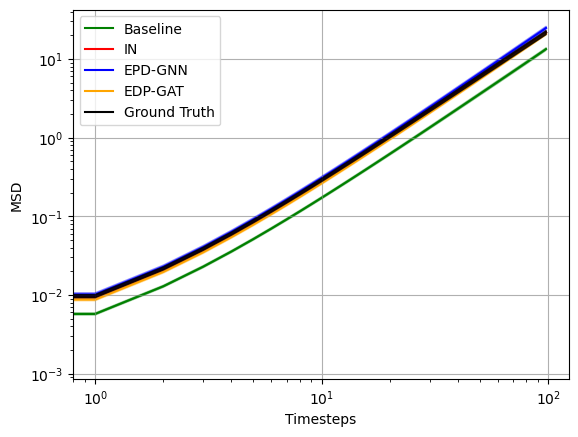

In [94]:
res_msd = []

# plot of MSD


for i in range(len(PATH)):
    print(MSD_list_noisy[i][:limit_msd].shape)
    msd_mean = np.mean(MSD_list_noisy[i][:, :limit_msd], axis = 0)
    msd_std = np.std(MSD_list_noisy[i][:, :limit_msd], axis = 0)
    x = np.arange(limit_msd)
    plt.loglog(x, msd_mean, color = colors[i], zorder = 1, label = str(l1[i]))
    plt.fill_between((x), (msd_mean - msd_std), (msd_mean+msd_std), color = colors[i], alpha = 0.4, zorder = 2)
    
    res_msd.append(msd_mean)
    
msd_mean = np.mean(MSD_base_noisy[:, :limit_msd], axis = 0)
msd_std = np.std(MSD_base_noisy[:, :limit_msd], axis = 0)
x = np.arange(limit_msd)
plt.loglog(x, msd_mean, color = 'k', zorder = 1, label = 'Ground Truth')
plt.fill_between((x), (msd_mean - msd_std), (msd_mean+msd_std), color = 'k', alpha = 0.8, zorder = 2)
    
plt.xlabel('Timesteps')
plt.ylabel('MSD')
plt.grid()
plt.legend()
plt.savefig('MSD-simplest-noisy.png')



In [95]:
msd_gt = np.mean(MSD_base_noisy[:, :limit_msd], axis = 0)

In [96]:
for i in range(len(res_msd)):
    delta = (msd_gt - res_msd[i]) ** 2
    print(f'l1: {l1[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

l1: Baseline >>>> 15.114146444410911 +- 19.367959819408277
l1: IN >>>> 0.00017093160627546777 +- 0.00014876259544286703
l1: EPD-GNN >>>> 1.6350028731757726 +- 2.445067421748264
l1: EDP-GAT >>>> 0.24927376408866847 +- 0.2507248705207714


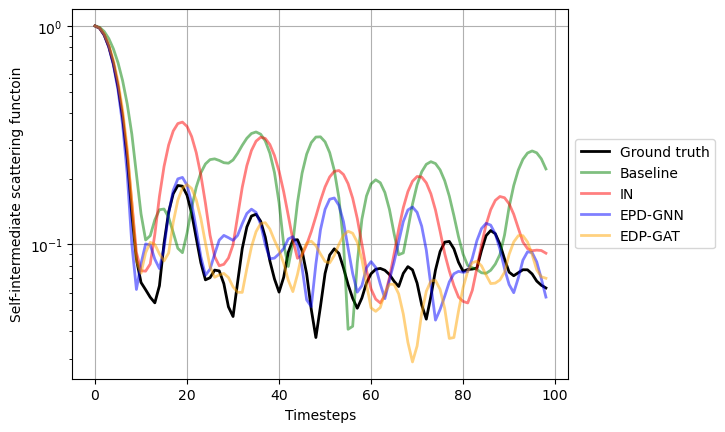

In [97]:
# plot of SSF

res_scat = []



ssf_mean = np.mean(SCAT_base_noisy[:, :limit_scat], axis = 0)
ssf_std = np.std(SCAT_base_noisy[:, :limit_scat], axis = 0)
t = np.arange(limit_scat)
plt.semilogy(t, ssf_mean, color = 'k', lw=2, label = 'Ground truth')
#plt.fill_between(t, ssf_mean -ssf_std,  ssf_mean + ssf_std, color = 'k', alpha = 0.2, zorder = 3)


for i in range(len(PATH)):
    #print(MSD_list_noisy[i][:limit_scat].shape)
    ssf_mean = np.mean(SCAT_list_noisy[i][:, :limit_scat], axis = 0)
    ssf_std = np.std(SCAT_list_noisy[i][:, :limit_scat], axis = 0)
    t = np.arange(limit_scat)
    plt.semilogy(t, ssf_mean, color = colors[i], lw=2, label = str(l1[i]), alpha = 0.5)
    res_scat.append(ssf_mean)
    #plt.fill_between(t, ssf_mean -ssf_std,  ssf_mean + ssf_std, color = colors[i], alpha = 0.4, zorder = 2)
    
plt.xlabel('Timesteps')
plt.ylabel('Self-intermediate scattering functoin')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('scat-simplest-noisy.png', bbox_inches='tight')
plt.show()

In [98]:
scat_gt = np.mean(SCAT_base_noisy[:, :limit_scat], axis = 0)

for i in range(len(res_scat)):
    delta = (scat_gt - res_scat[i]) ** 2
    print(f'l1: {l1[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

l1: Baseline >>>> 0.016165507983854445 +- 0.016580310239454655
l1: IN >>>> 0.00795288295646177 +- 0.010515967050799923
l1: EPD-GNN >>>> 0.0009146918707281062 +- 0.001406258329205755
l1: EDP-GAT >>>> 0.0009015884921106545 +- 0.0009810424713280537


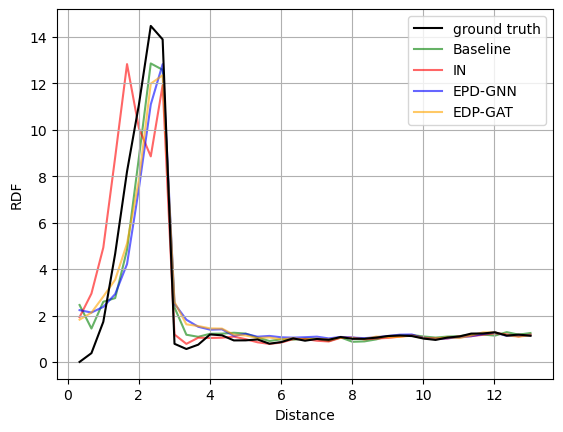

In [99]:
mean_res, std_res, r = RDF_base_noisy
lim_rdf = 40

res_rdf = []


mean_res, std_res, r = mean_res[1:lim_rdf], std_res[1: lim_rdf], r[1: lim_rdf]

plt.plot(r, mean_res, color = 'k', label = 'ground truth', zorder = 2)
#plt.fill_between(r, mean_res - std_res, mean_res+ std_res, color = 'k', alpha = 0.4)

for i in range(len(PATH)):
    #print(MSD_list_noisy[i][:limit_scat].shape)
    mean_res, std_res, r = RDF_list_noisy[i]
    mean_res, std_res, r = mean_res[1:lim_rdf], std_res[1: lim_rdf], r[1: lim_rdf]
    
    plt.plot(r, mean_res, color = colors[i], label = str(l1[i]), alpha = 0.6, zorder = 1)
    #plt.fill_between(r, mean_res -std_res,  mean_res + std_res, color = colors[i], alpha = 0.4, zorder = 2)
    
    res_rdf.append(mean_res)

plt.xlabel('Distance')
plt.ylabel('RDF')
plt.grid()
plt.legend()


plt.savefig('rdf-simplest-noisy.png')
plt.show()

In [100]:
mean_res, std_res, r = RDF_base_noisy
mean_res, std_res, r = mean_res[1:lim_rdf], std_res[1: lim_rdf], r[1: lim_rdf]
rdf_gt = np.mean(mean_res, axis = 0)

for i in range(len(res_rdf)):
    delta = (rdf_gt - res_rdf[i]) ** 2
    print(f'l1: {l1[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

l1: Baseline >>>> 7.9673974033007 +- 24.832662831030156
l1: IN >>>> 10.477313997626776 +- 25.429205501527353
l1: EPD-GNN >>>> 6.621804086179261 +- 21.54942772583855
l1: EDP-GAT >>>> 7.093522254003383 +- 22.036929574714602


IndexError: list index out of range

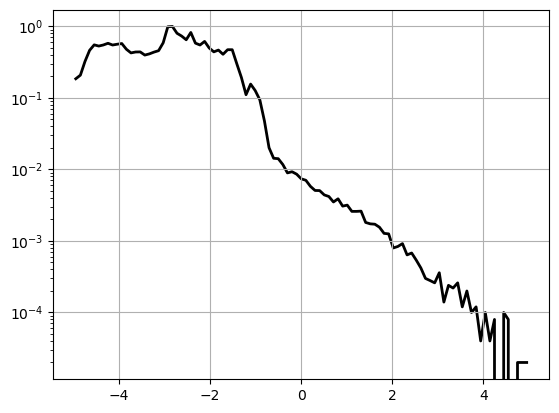

In [90]:
magn_base, x_speed, y_speed = DISTR_base_noisy

magn_base_mean = np.mean(magn_base, axis = 0)
magn_base_std = np.std(magn_base, axis = 0)

res_magn_distr = []


fig=plt.figure()
db=b[1]-b[0]
plt.grid()
plt.semilogy(b[1:]-db/2,magn_base_mean,'k',lw=2, zorder = 1, label = 'Ground truth')
#plt.fill_between(b[1:]-db/2, magn_base_mean - magn_base_std, magn_base_mean + magn_base_std, color = 'r', alpha = 0.4)


for i in range(len(PATH)):
    magn, x, y = DISTR_list_noisy[i]
    magn_base_mean = np.mean(magn, axis = 0)
    magn_base_std = np.std(magn, axis = 0)
    plt.semilogy(b[1:]-db/2,magn_base_mean, color = colors[i],lw=2, label = str(l1[i]), zorder = 2, alpha = 0.6)
    
    res_magn_distr.append(magn_base_mean)



plt.xlabel('v/<v>')
plt.ylabel('P(frac{v}{<v>})')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('speed-magn-simplest-noisy.png', bbox_inches='tight')
plt.show()

In [ ]:
magn_base, x_speed, y_speed = DISTR_base_noisy

magn_base_mean = np.mean(magn_base, axis = 0)

magn_gt = magn_base_mean

for i in range(len(res_magn_distr)):
    delta = (magn_gt - res_magn_distr[i]) ** 2
    print(f'l1: {l1[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

IndexError: list index out of range

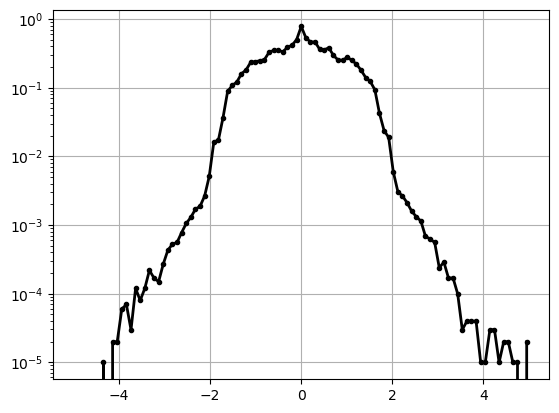

In [86]:
magn_base_mean = np.mean(x_speed, axis = 0)
magn_base_std = np.std(x_speed, axis = 0)

res_magn_x = []


fig=plt.figure()
db=b[1]-b[0]
plt.grid()
plt.semilogy(b[1:]-db/2,magn_base_mean,'k.-',lw=2, label = 'Ground truth')
#plt.fill_between(b[1:]-db/2, magn_base_mean - magn_base_std, magn_base_mean + magn_base_std, color = 'r', alpha = 0.4)


for i in range(len(PATH)):
    magn, x, y = DISTR_list_noisy[i]
    x_base_mean = np.mean(x, axis = 0)
    x_base_std = np.std(x, axis = 0)
    plt.semilogy(b[1:]-db/2,x_base_mean, color = colors[i],lw=2, label = str(l1[i]), zorder = 2, alpha = 0.6)
    
    
    res_magn_x.append(x_base_mean)

    
plt.xlabel('v/<v>')
plt.ylabel('P(frac{v}{<v>})')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('speed-x-simplest-noisy.png', bbox_inches='tight')
plt.show()

In [66]:
magn_base, x_speed, y_speed = DISTR_base_noisy

magn_base_mean = np.mean(x_speed, axis = 0)

magn_gt = magn_base_mean

for i in range(len(res_magn_x)):
    delta = (magn_gt - res_magn_x[i]) ** 2
    print(f'l1: {l1[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

l1: Baseline >>>> 0.017267282084104583 +- 0.06786987284674847
l1: IN >>>> 0.018784727678543455 +- 0.1425729071558774
l1: EPD-GNN >>>> 0.0032056007359313817 +- 0.01219377792513681
l1: EDP-GAT >>>> 0.0031210083479929675 +- 0.009971773064525754


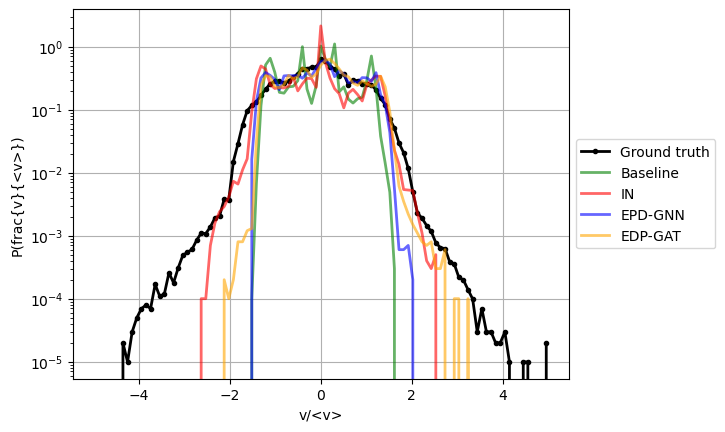

In [67]:
magn_base_mean = np.mean(y_speed, axis = 0)
magn_base_std = np.std(y_speed, axis = 0)

res_magn_y = []


fig=plt.figure()
db=b[1]-b[0]
plt.grid()
plt.semilogy(b[1:]-db/2,magn_base_mean,'k.-',lw=2, label = 'Ground truth')
#plt.fill_between(b[1:]-db/2, magn_base_mean - magn_base_std, magn_base_mean + magn_base_std, color = 'r', alpha = 0.4)


for i in range(len(PATH)):
    magn, x, y = DISTR_list_noisy[i]
    y_base_mean = np.mean(y, axis = 0)
    y_base_std = np.std(y, axis = 0)
    plt.semilogy(b[1:]-db/2,y_base_mean, color = colors[i],lw=2, label = str(l1[i]), zorder = 2, alpha = 0.6)
    
    res_magn_y.append(y_base_mean)

plt.xlabel('v/<v>')
plt.ylabel('P(frac{v}{<v>})')




plt.xlabel('v/<v>')
plt.ylabel('P(frac{v}{<v>})')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('speed-y-simplest-noisy.png', bbox_inches='tight')
plt.show()

In [68]:
magn_base, x_speed, y_speed = DISTR_base_noisy

magn_base_mean = np.mean(y_speed, axis = 0)

magn_gt = magn_base_mean

for i in range(len(res_magn_y)):
    delta = (magn_gt - res_magn_y[i]) ** 2
    print(f'l1: {l1[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

l1: Baseline >>>> 0.01835258622327484 +- 0.06110077469637585
l1: IN >>>> 0.02964917167964064 +- 0.22741061282416025
l1: EPD-GNN >>>> 0.002162405344213986 +- 0.005867275685816422
l1: EDP-GAT >>>> 0.0023669435515121942 +- 0.0058207961688059


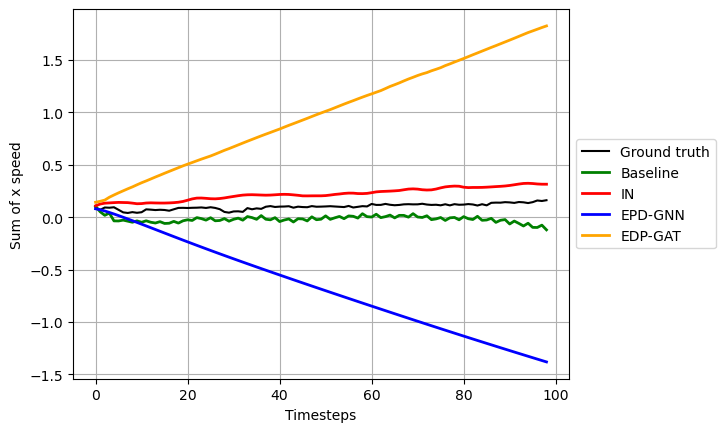

In [69]:
mean_sum = np.mean(SUM_base_noisy, axis = 0)
std_sum = np.std(SUM_base_noisy, axis = 0)

liit_sum = 300

plt.plot(mean_sum[:liit_sum, 0], color = 'k', label = 'Ground truth')


for i in range(len(PATH)):
    sum_mean = np.mean(SUM_list_noisy[i], axis = 0)
    sum_std = np.std(SUM_list_noisy[i], axis = 0)
    
    plt.plot(sum_mean[:liit_sum, 0], color = colors[i], lw=2, label = str(l1[i]))

    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.xlabel('Timesteps')
plt.ylabel('Sum of x speed')

plt.savefig('speed-sum-x-simplest-noisy.png', bbox_inches='tight')
plt.show()

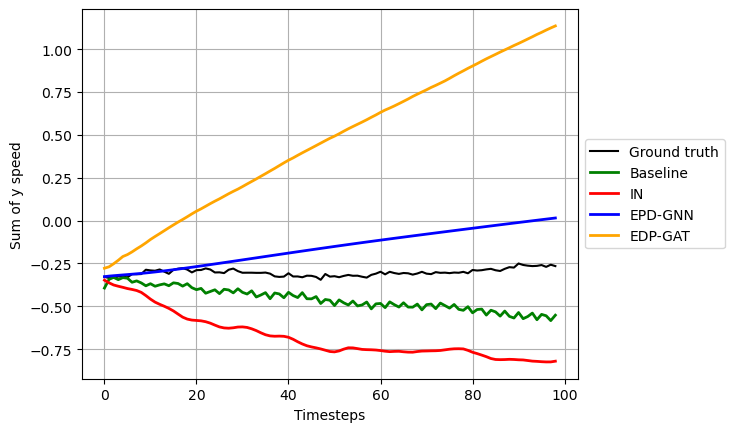

In [70]:
mean_sum = np.mean(SUM_base_noisy, axis = 0)
std_sum = np.std(SUM_base_noisy, axis = 0)

liit_sum = 300

plt.plot(mean_sum[:liit_sum, 1], color = 'k', label = 'Ground truth')


for i in range(len(PATH)):
    sum_mean = np.mean(SUM_list_noisy[i], axis = 0)
    sum_std = np.std(SUM_list_noisy[i], axis = 0)
    
    plt.plot(sum_mean[:liit_sum, 1], color = colors[i], lw=2, label = str(l1[i]))

    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.xlabel('Timesteps')
plt.ylabel('Sum of y speed')


#plt.ylim([np.min(mean_sum[:liit_sum, 1])- 0.5, np.max(mean_sum[:liit_sum, 1])+ 0.5])

plt.savefig('speed-sum-y-simplest-noisy.png', bbox_inches='tight')
plt.show()

In [71]:
print(MSE_rollout_noisy[0].shape)

(5, 100)


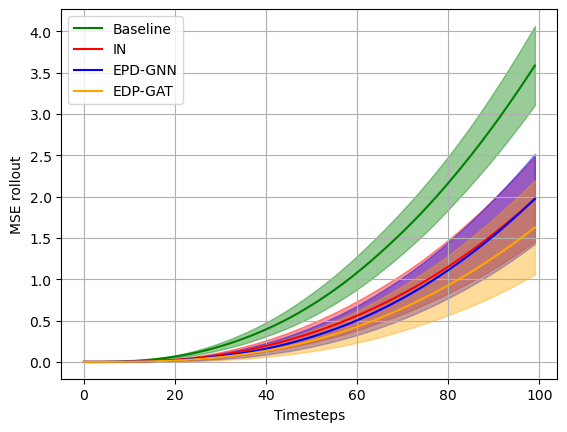

In [72]:
for i in range(len(PATH)):
    m_mean = np.mean(MSE_rollout_noisy[i], axis = 0)
    m_std = np.std(MSE_rollout_noisy[i], axis = 0)
    
    x_inds = np.arange(m_mean.shape[0])
    plt.plot(x_inds, m_mean, color = colors[i], label = l1[i])
    
    plt.fill_between(x_inds, m_mean - m_std, m_mean +m_std, color = colors[i], alpha = 0.4)
    
plt.grid()
plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('MSE rollout')
plt.savefig('MSE rollout noisy.png')


In [73]:
print(m_mean.shape)

(100,)


In [74]:
print(MSE_rollout)

[array([[1.21904717e-03, 7.55445874e-04, 4.86727133e-04, 6.45267963e-04,
        1.44782645e-03, 2.98019798e-03, 5.27595033e-03, 8.36566563e-03,
        1.22322762e-02, 1.70067560e-02, 2.27173338e-02, 2.93952036e-02,
        3.70629563e-02, 4.57434635e-02, 5.54656304e-02, 6.62793992e-02,
        7.82483522e-02, 9.13936990e-02, 1.05596367e-01, 1.20893945e-01,
        1.37338207e-01, 1.54970869e-01, 1.73779490e-01, 1.93569599e-01,
        2.14372879e-01, 2.36242784e-01, 2.59254725e-01, 2.83334138e-01,
        3.08455017e-01, 3.34123139e-01, 3.60934856e-01, 3.88866301e-01,
        4.17965222e-01, 4.48298719e-01, 4.79941480e-01, 5.12938167e-01,
        5.47425590e-01, 5.83354786e-01, 6.20711089e-01, 6.59664184e-01,
        7.00363914e-01, 7.42874241e-01, 7.86688612e-01, 8.31236856e-01,
        8.76459457e-01, 9.22333534e-01, 9.68516528e-01, 1.01551125e+00,
        1.06342404e+00, 1.11243271e+00, 1.16259692e+00, 1.21396942e+00,
        1.26670220e+00, 1.32087218e+00, 1.37659268e+00, 1.43290

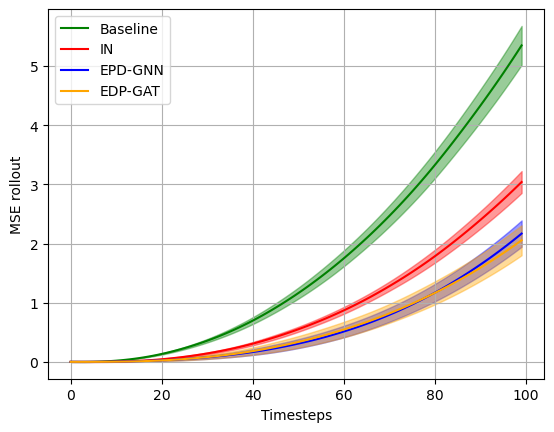

In [75]:
for i in range(len(PATH)):
    m_mean = np.mean(MSE_rollout[i], axis = 0)
    m_std = np.std(MSE_rollout[i], axis = 0)
    
    x_inds = np.arange(m_mean.shape[0])
    plt.plot(x_inds, m_mean, color = colors[i], label = l1[i])
    
    plt.fill_between(x_inds, m_mean - m_std, m_mean +m_std, color = colors[i], alpha = 0.4)
    
    #plt.fill_between()
    
plt.grid()
plt.xlabel('Timesteps')
plt.ylabel('MSE rollout')
plt.legend()
plt.savefig('MSE rollout normal.png')